<a href="https://www.kaggle.com/code/vicmangiltafolla/analysis-and-restoration-of-the-cabin-column?scriptVersionId=157100418" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

The 'Cabin' column is the one that by far has the most null value with around 3/4 of the total samples, so it makes a lot of sense to ignore and delete it from the dataset.

With all these null values, most of the imputation techniques don't really work and fail to correctly represent the missing data.

This means that a further analysis is required, using the small existent data of the Cabin column and its correlation with other columns to map the missing samples. 

In this notebook, we are going to perform that anaysis and try to restore the Cabin column as much as possible. 

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.svm import SVC
from sklearn. model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier

# Reading

In [2]:
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def TextProcess(row):
    #Clean the name attribute from punctuation marks 
    row = row.lower().replace('.', '')
    titles = ["master", "mr", "miss", "mrs", "ms", "sir", "lady", "dr", "rev", "fr", "capt", "col", "mme",
               "major", "mlle", "jonkheer", "countess", "uruchurtu", "dona"]
    #Replace the Name attribute with their corresponding title
    for name in str(row).split():
        if name in titles:
            return name

def process_age(row):
    #Classify people by age
    if row < 6:
        return 'EarlyChild'
    elif row < 12:
        return 'Childhood'
    elif row < 18:
        return 'Teen'
    elif row < 35:
        return 'YoungAdult'
    elif row < 60:
        return 'Adult'
    elif row > 60:
        return 'Elder'

def process_cabin1(row):
    #returns the letter or deck of the cabin
    letter = re.search(r'([A-Z])([0-9]+)', str(row))
    if letter: 
        return letter[1]
    
def process_cabin2(row):
    #retunrs the number of the cabin
    letter = re.search(r'([A-Z])([0-9]+)', str(row))
    if letter: 
        return float(letter[2])
    
def process_cabin_num(row):
    #Classify the cabin number
    if row < 21:
        return '0-20'
    elif row < 41:
        return '21-40'
    elif row < 61:
        return '41-60'
    elif row < 81:
        return '61-80'
    elif row < 101:
        return '81-100'
    elif row < 121:
        return '101-120'
    elif row > 120:
        return '>120'
    else:
        return np.nan

def process_fam(row):
    #Classify the size of the sum of parch and sibsp
    if row == 0:
        return 'Alone'
    elif row < 3:
        return 'Small'
    elif row < 5:
        return 'Medium'
    elif row < 7:
        return 'Big'
    else:
        return 'ReallyBig'
    
def process_fare(row):
    #Classify fare using percentiles
    if row <=7.9104:
        return 'low_fare'
    elif row <=14.4542:
        return 'low_medium_fare'
    elif row <= 31:
        return 'high_medium_fare'
    elif row <= 75:
        return 'high_fare'
    else:
        return 'extreme_fare'

# Preprocessing 

As there are too little No null rows in the dataset, we are going to combine the test and train set to have a more complete image of the Cabin correlation

In [4]:
X = pd.concat([df_train.drop('Survived', axis=1), df_test])
X.index = X['PassengerId']
X.drop('PassengerId', axis=1, inplace=True)
X

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [5]:
# Process the columns to perform the analysis
X['Name'] = X['Name'].apply(TextProcess)
X['Age'] = X['Age'].apply(process_age)
X['Fare'] = X['Fare'].apply(process_fare)
X['Cabin_letter'] = X['Cabin'].apply(process_cabin1)
X['Cabin_num'] = X['Cabin'].apply(process_cabin2)
X['Cabin_num'] = X['Cabin_num'].apply(process_cabin_num)
X['Family'] = X['SibSp'] + X['Parch']
X['Family'] = X['Family'].apply(process_fam)
X.drop(['SibSp', 'Parch'], axis=1, inplace=True)
X

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
1,3,mr,male,YoungAdult,A/5 21171,low_fare,NaN,S,None,NaN,Small
2,1,mrs,female,Adult,PC 17599,high_fare,C85,C,C,81-100,Small
3,3,miss,female,YoungAdult,STON/O2. 3101282,low_medium_fare,NaN,S,None,NaN,Alone
4,1,mrs,female,Adult,113803,high_fare,C123,S,C,>120,Small
5,3,mr,male,Adult,373450,low_medium_fare,NaN,S,None,NaN,Alone
...,...,...,...,...,...,...,...,...,...,...,...
1305,3,mr,male,None,A.5. 3236,low_medium_fare,NaN,S,None,NaN,Alone
1306,1,dona,female,Adult,PC 17758,extreme_fare,C105,C,C,101-120,Alone
1307,3,mr,male,Adult,SOTON/O.Q. 3101262,low_fare,NaN,S,None,NaN,Alone


## Pre Visualization 

If we plot the count of each letter and number range, it's clear that there is an heterogenious distribution so that come values have a way higher count that other. 

This lack of information can be a problem when it comes to determine the characteristics of a passenger of a certain deck

<Axes: xlabel='Cabin_letter', ylabel='count'>

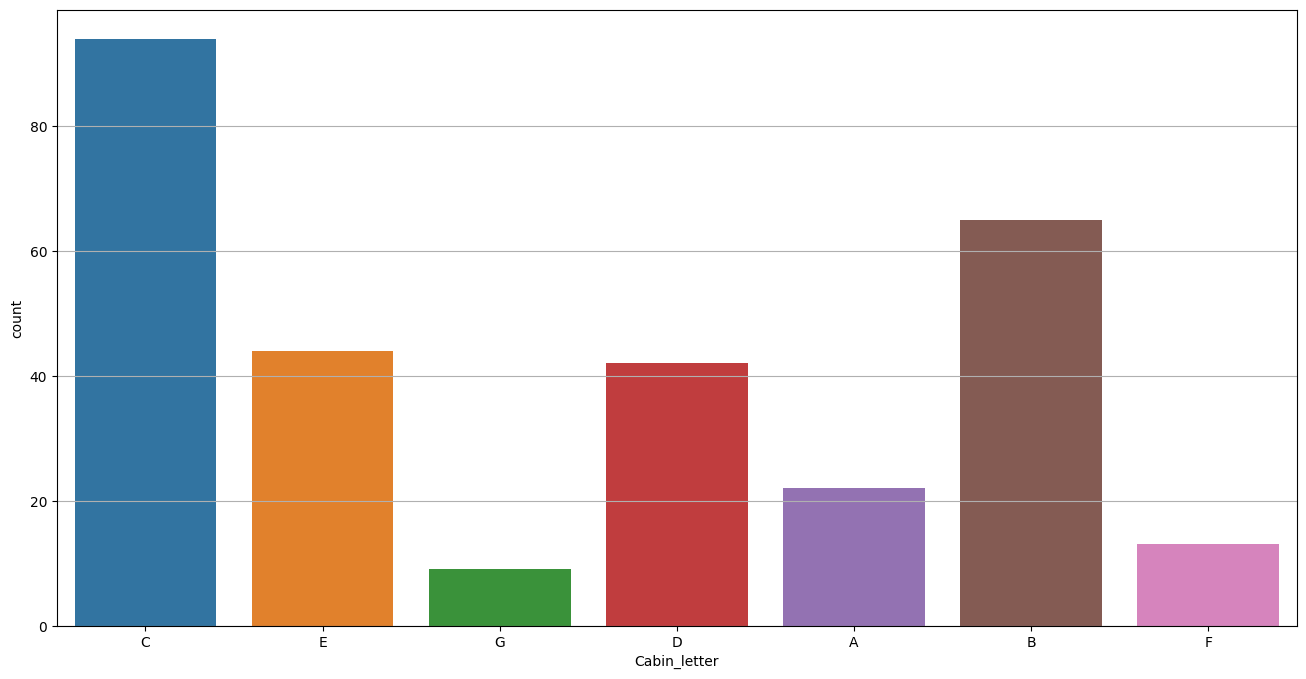

In [6]:
plt.figure(figsize=(16,8))
plt.grid()
sns.countplot(data=X, x='Cabin_letter')

It's important to have information about each deck, so we can understand even more the type of passenger that traveled there. 

- A Deck, also called the promenade deck, extended along the entire 546 feet (166 m) length of the superstructure. It was reserved exclusively for First Class passengers and contained First Class cabins, the First Class lounge, smoke room, reading and writing rooms, and Palm Court.

- B Deck, the bridge deck, was the top weight-bearing deck and the uppermost level of the hull. More First Class passenger accommodations were located here with six palatial staterooms (cabins) featuring their own private promenades. On Titanic, the à la carte restaurant and the Café Parisien provided luxury dining facilities to First Class passengers. Both were run by subcontracted chefs and their staff; all were lost in the disaster. The Second Class smoking room and entrance hall were both located on this deck. The raised forecastle of the ship was forward of the bridge deck, accommodating Number 1 hatch (the main hatch through to the cargo holds), numerous pieces of machinery and the anchor housings.Aft of the bridge deck was the raised poop deck, 106 feet (32 m) long, used as a promenade by Third Class passengers. It was where many of Titanic's passengers and crew made their last stand as the ship sank. The forecastle and poop deck were separated from the bridge deck by well decks.

- C Deck, the shelter deck, was the highest deck to run uninterrupted from stem to stern. It included both well decks; the aft one served as part of the Third Class promenade. Crew cabins were housed below the forecastle and Third Class public rooms were housed below the poop deck. In between were the majority of First Class cabins and the Second Class library.

- D Deck, the saloon deck, was dominated by three large public rooms—the First Class reception room, the First Class dining saloon and the Second Class dining saloon. An open space was provided for Third Class passengers. First, Second and Third Class passengers had cabins on this deck, with berths for firemen located in the bow. It was the highest level reached by the ship's watertight bulkheads (though only by eight of the fifteen bulkheads).

- E Deck, the upper deck, was predominantly used for passenger accommodation for all three classes plus berths for cooks, seamen, stewards and trimmers. Along its length ran a long passageway nicknamed 'Scotland Road', in reference to a famous street in Liverpool. Scotland Road was used by Third Class passengers and crew members.

- F Deck, the middle deck, was the last complete deck, and mainly accommodated Second and Third Class passengers and several departments of the crew. The Third Class dining saloon was located here, as were the swimming pool, Turkish bath and kennels.

- G Deck, the lower deck, was the lowest complete deck that carried passengers, and had the lowest portholes, just above the waterline. The squash court was located here along with the travelling post office where letters and parcels were sorted ready for delivery when the ship docked. Food was also stored here. The deck was interrupted at several points by orlop (partial) decks over the boiler, engine and turbine rooms.

[Source](https://en.wikipedia.org/wiki/Titanic#Dimensions_and_layout)

<Axes: xlabel='Cabin_num', ylabel='count'>

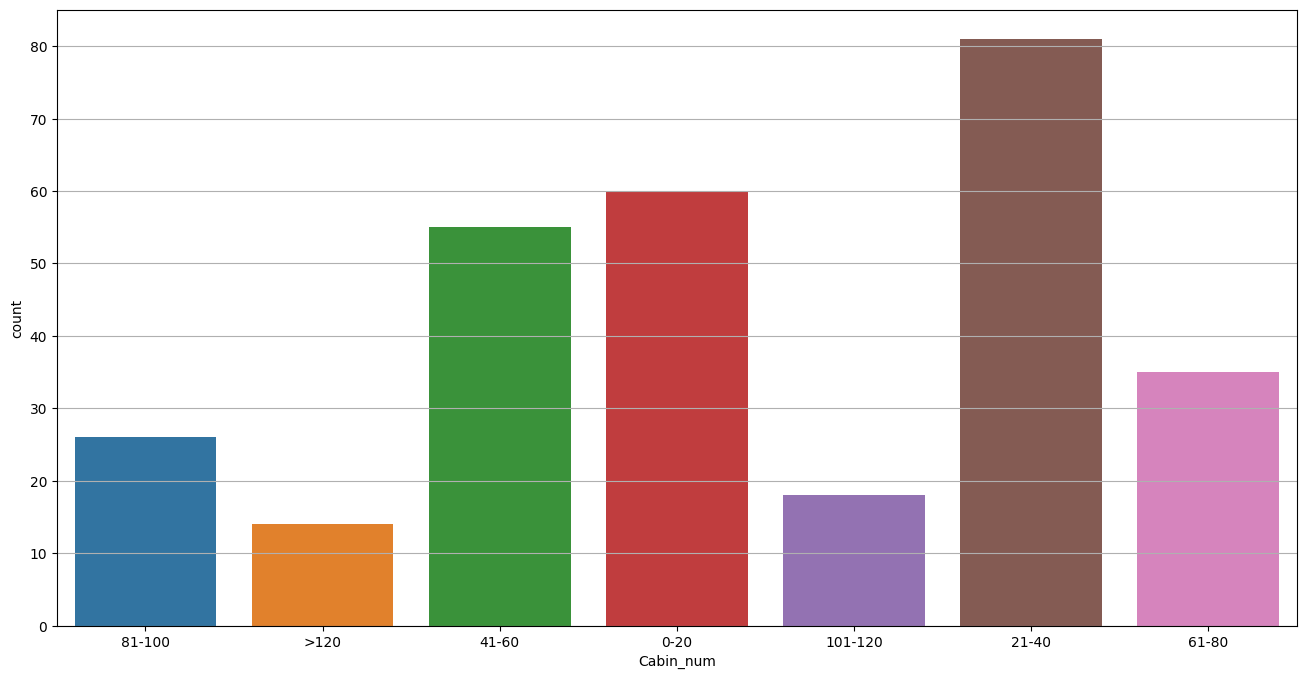

In [7]:
plt.figure(figsize=(16,8))
plt.grid()
sns.countplot(data=X, x='Cabin_num')

<Axes: xlabel='Cabin_num', ylabel='count'>

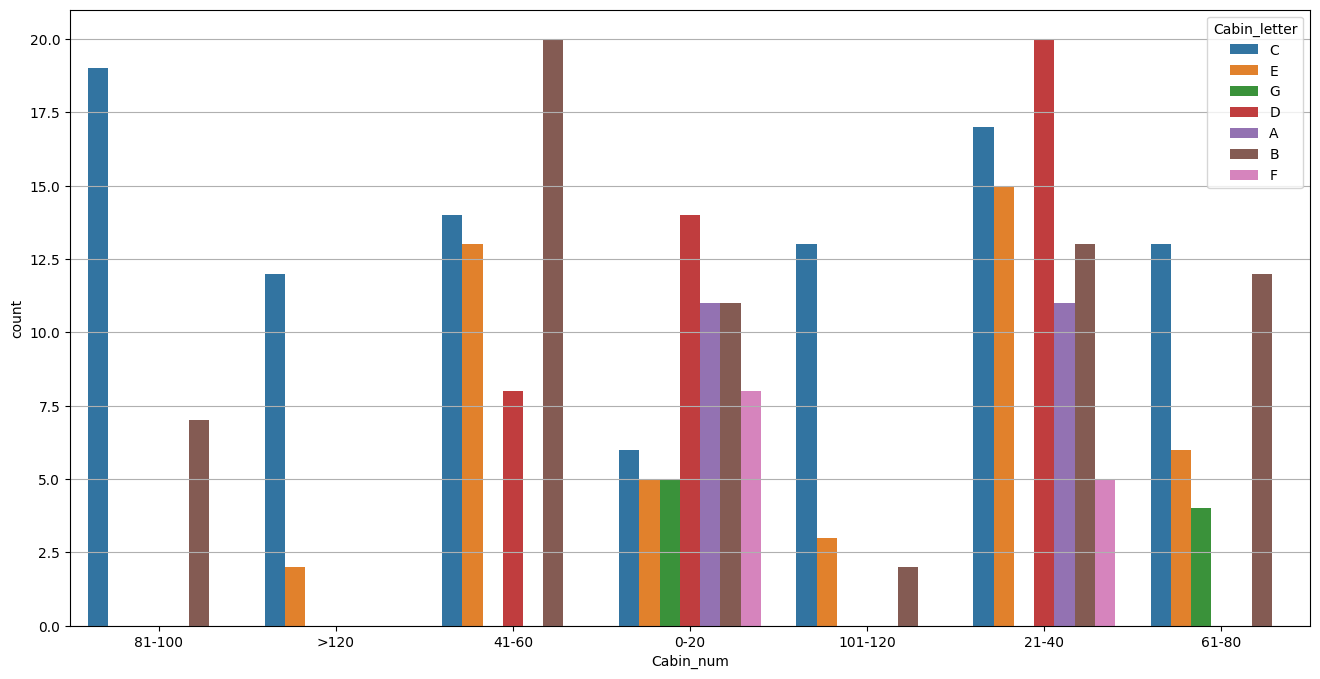

In [8]:
plt.figure(figsize=(16,8))
plt.grid()
sns.countplot(data=X, x='Cabin_num', hue='Cabin_letter')

We are going to use the other columns to input the missing values in Cabin, so it's important to know how each one correlates to the deck and number of it.

In order to make a more comprehensive plotting, let's compare the total amount of counts by value of each column and the cabin deck and number in that same value to see the proportion.

### Fare

<Axes: xlabel='Fare', ylabel='count'>

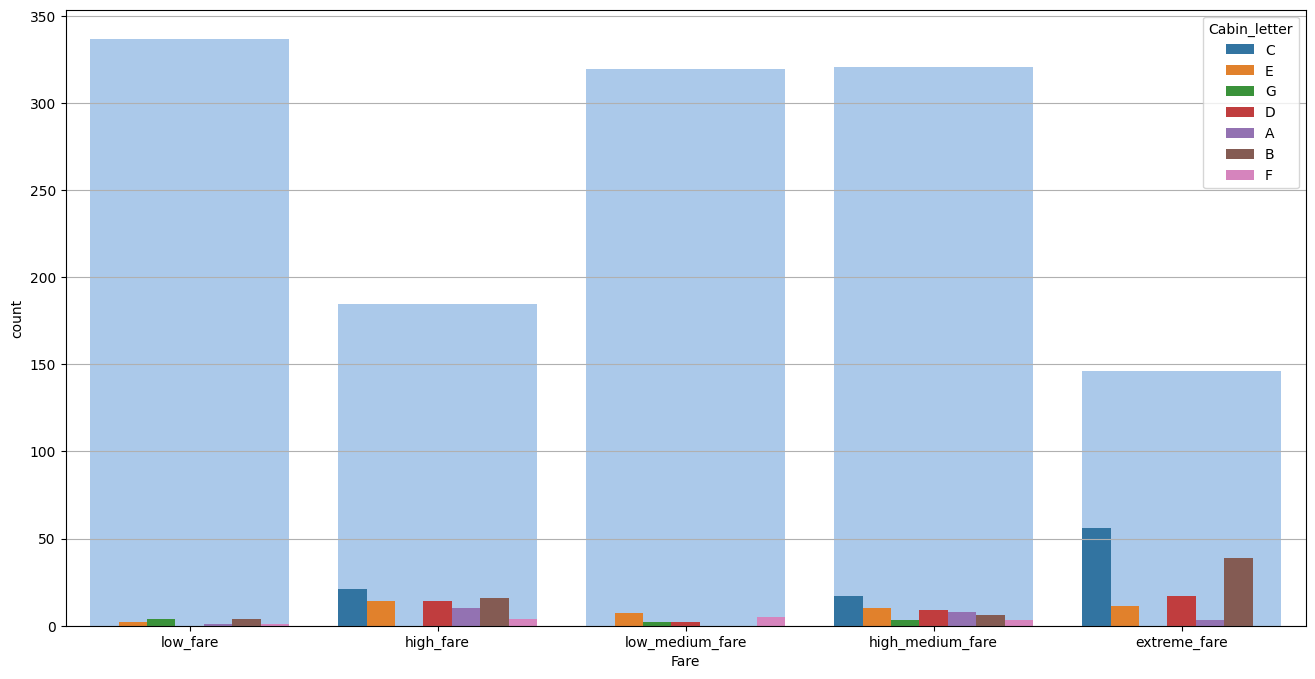

In [9]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Fare', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Fare', hue='Cabin_letter')

<Axes: xlabel='Fare', ylabel='count'>

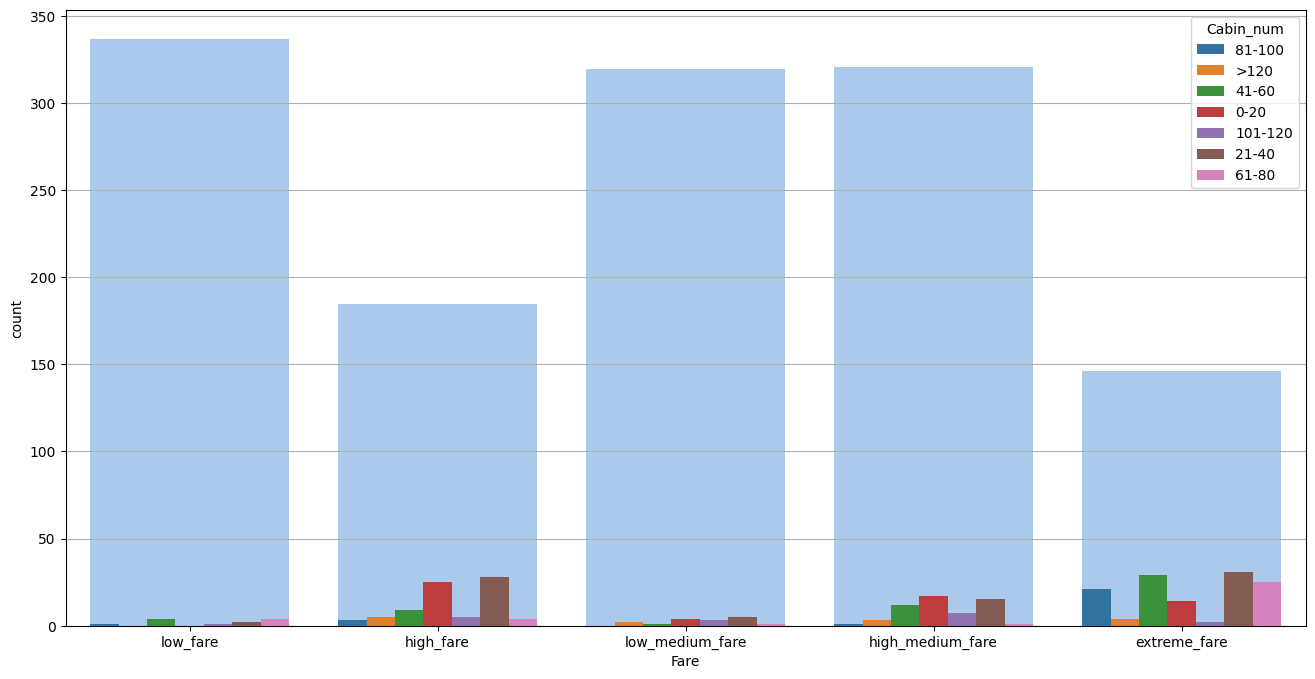

In [10]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Fare', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Fare', hue='Cabin_num')

### Pclass

<Axes: xlabel='Pclass', ylabel='count'>

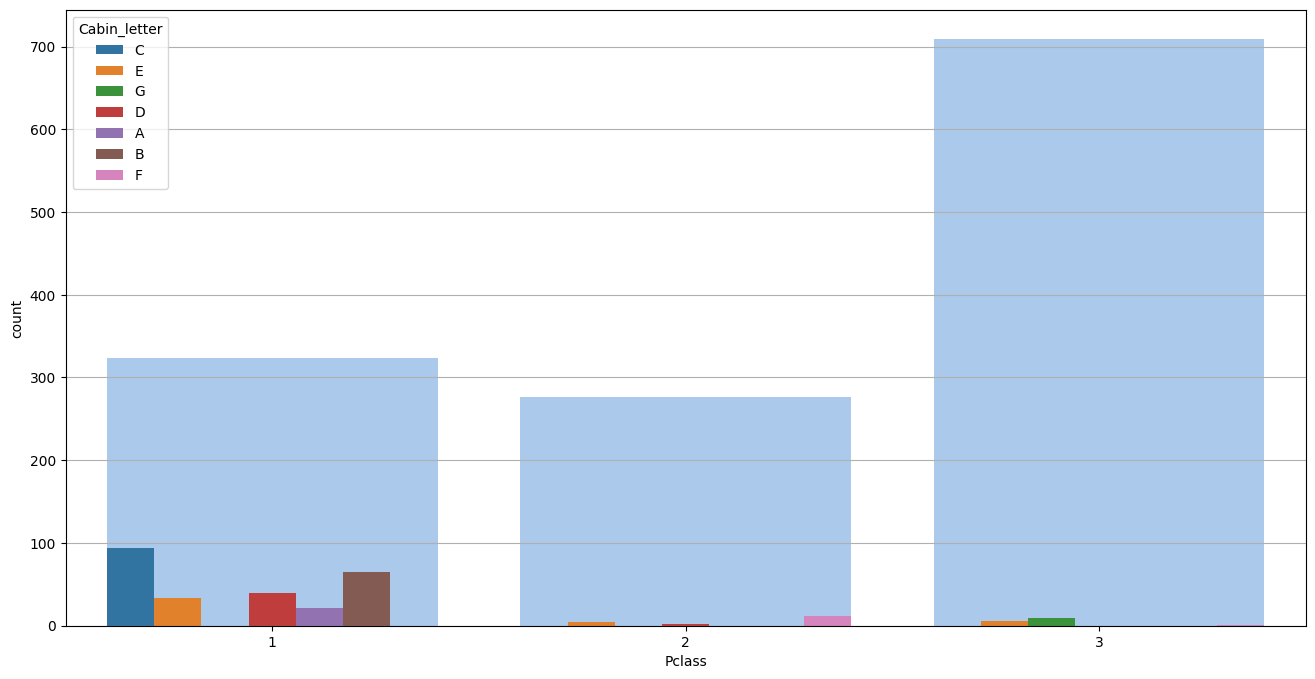

In [11]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Pclass', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Pclass', hue='Cabin_letter')

<Axes: xlabel='Pclass', ylabel='count'>

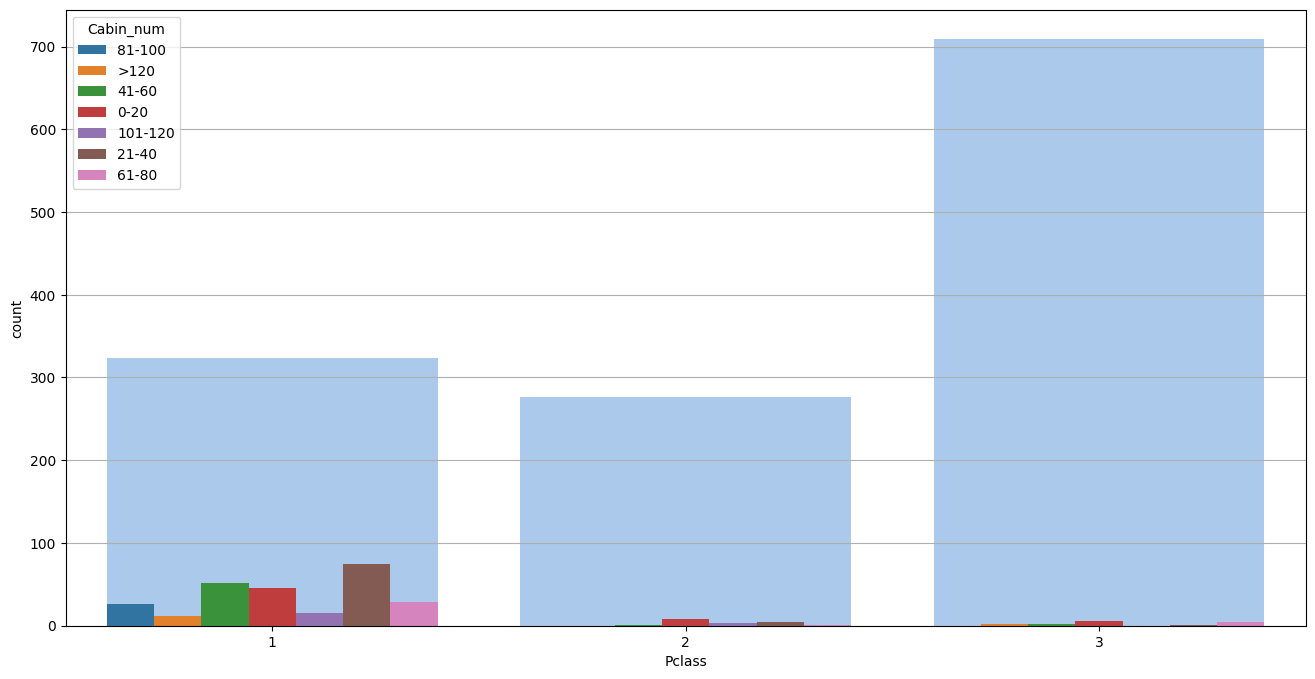

In [12]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Pclass', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Pclass', hue='Cabin_num')

Notice how extreme_fare, high_fare and pclass1 have most of the no null values from cabin even though they don't represent the most of the rows, and also the high socioeconomical related decks have a higher count. 

### Sex

<Axes: xlabel='Sex', ylabel='count'>

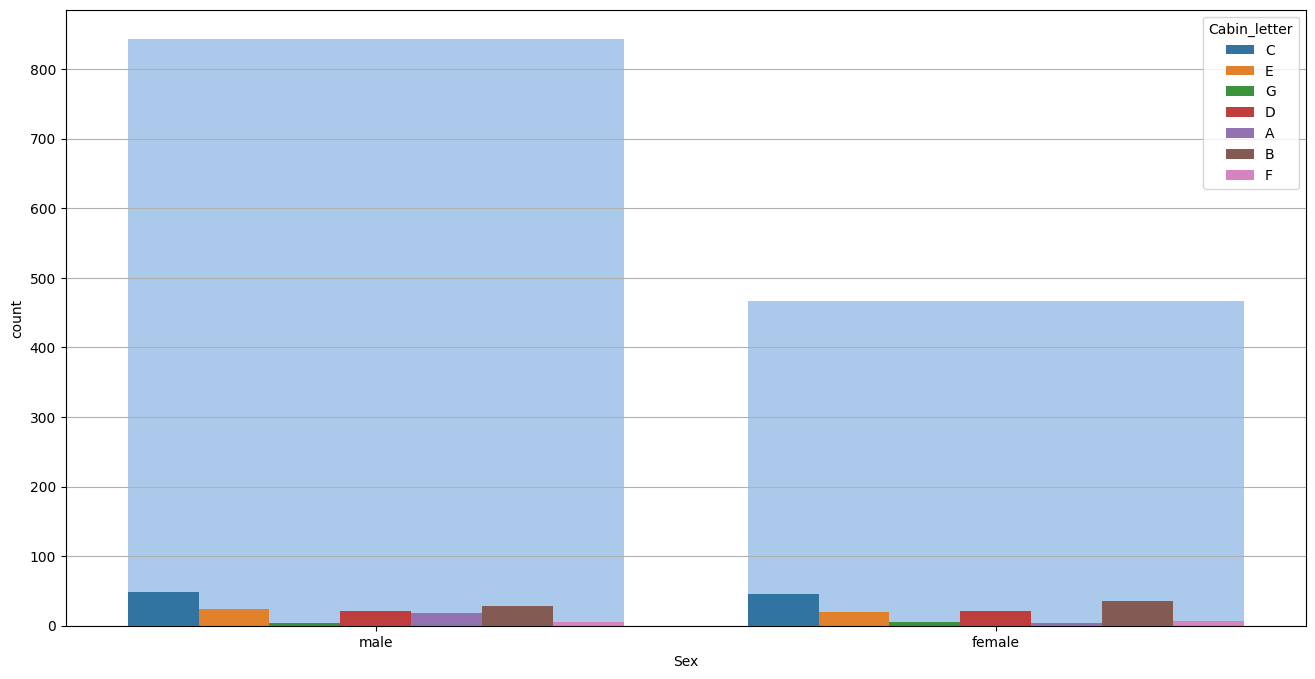

In [13]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Sex', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Sex', hue='Cabin_letter')

<Axes: xlabel='Sex', ylabel='count'>

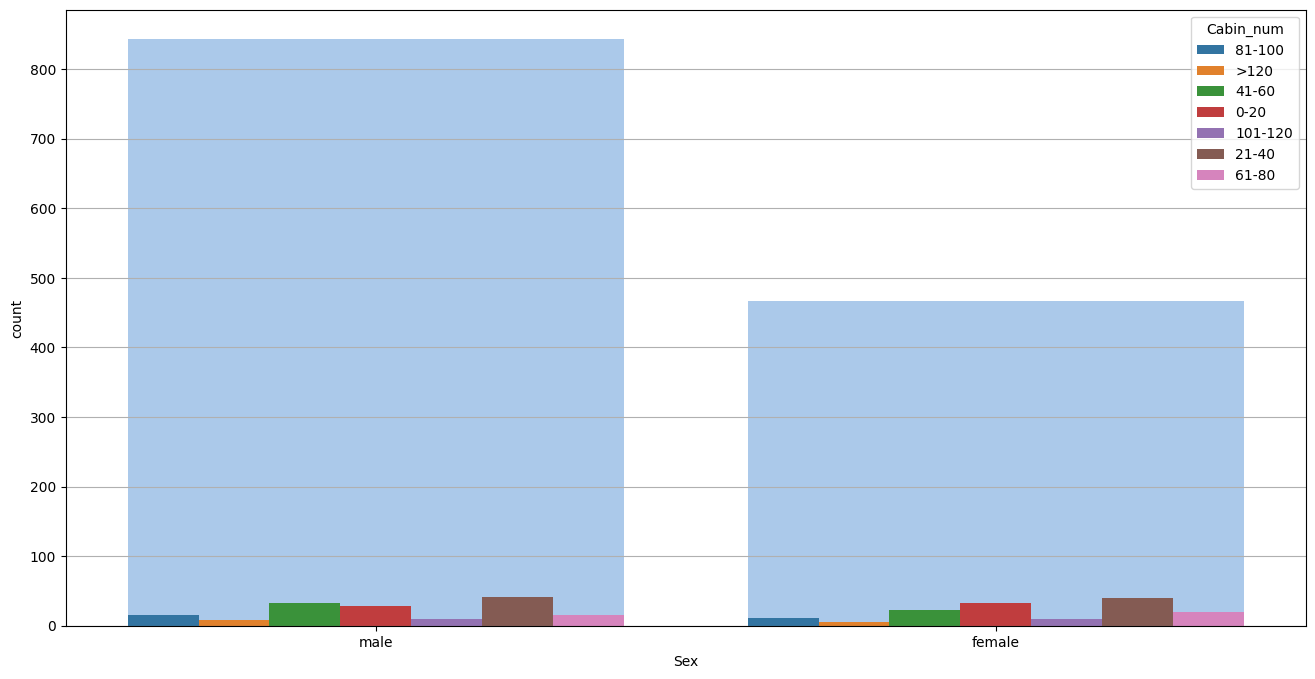

In [14]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Sex', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Sex', hue='Cabin_num')

### Age

<Axes: xlabel='Age', ylabel='count'>

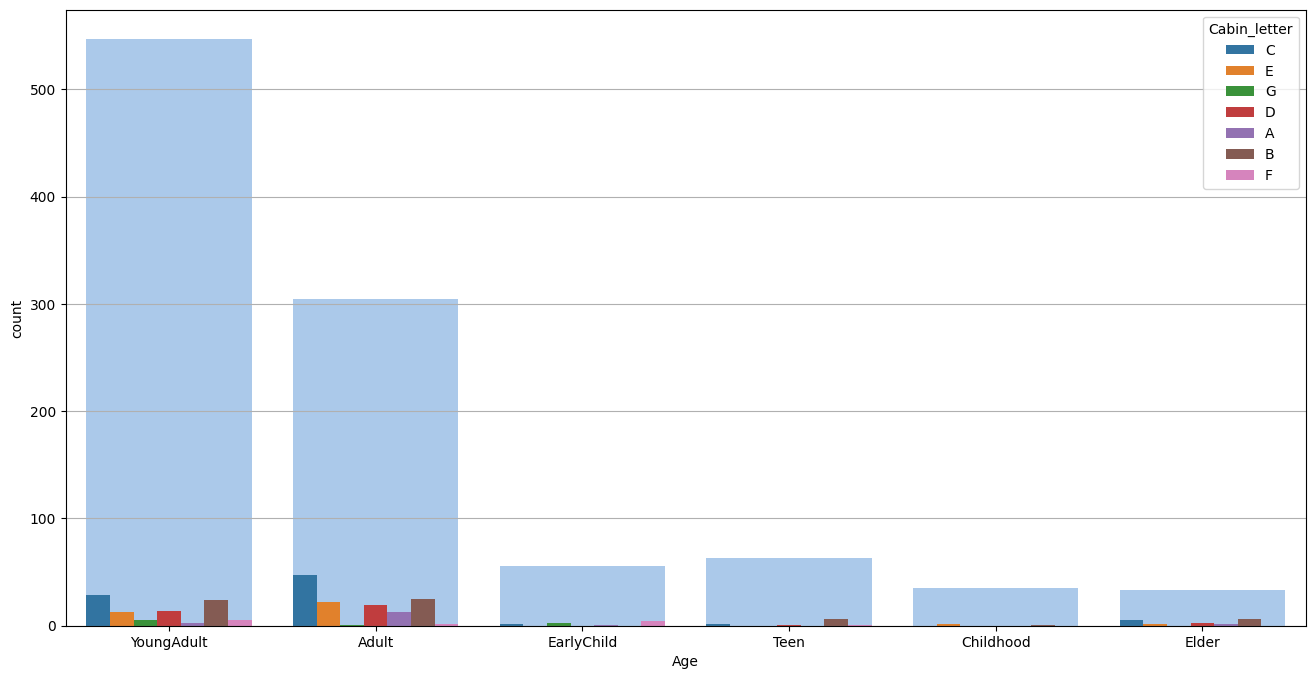

In [15]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Age', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Age', hue='Cabin_letter')

<Axes: xlabel='Age', ylabel='count'>

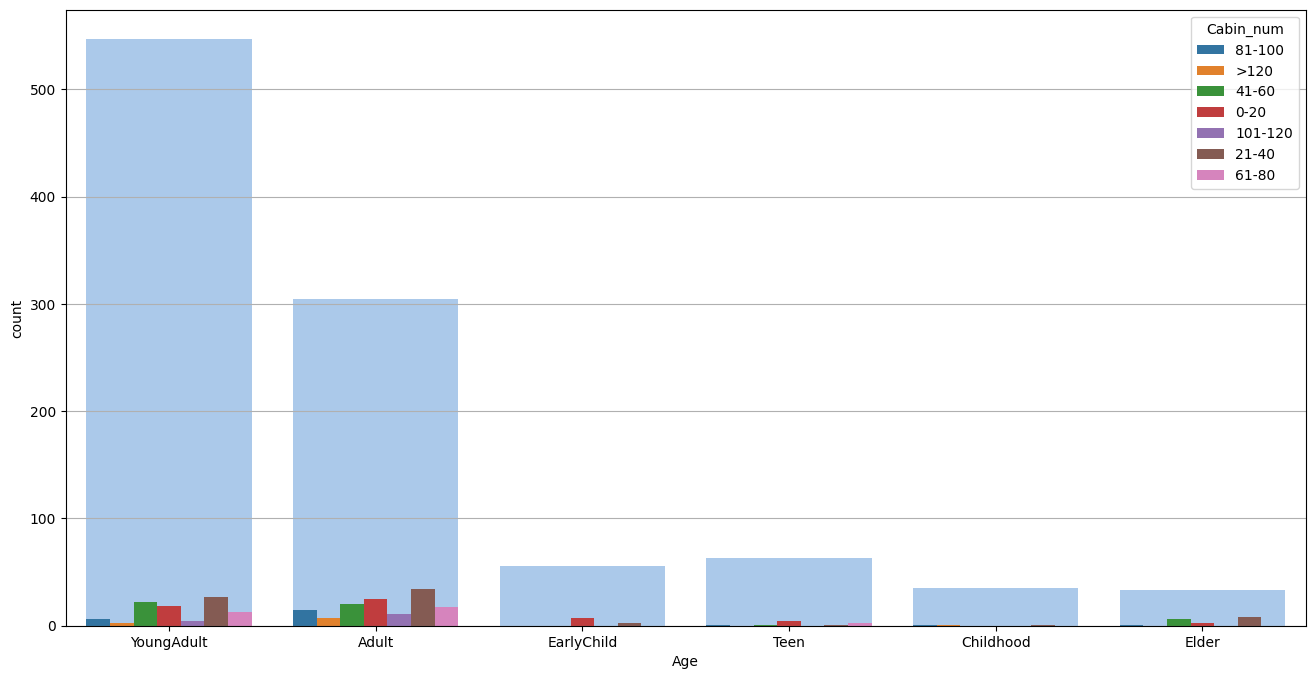

In [16]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Age', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Age', hue='Cabin_num')

### Embarked

<Axes: xlabel='Embarked', ylabel='count'>

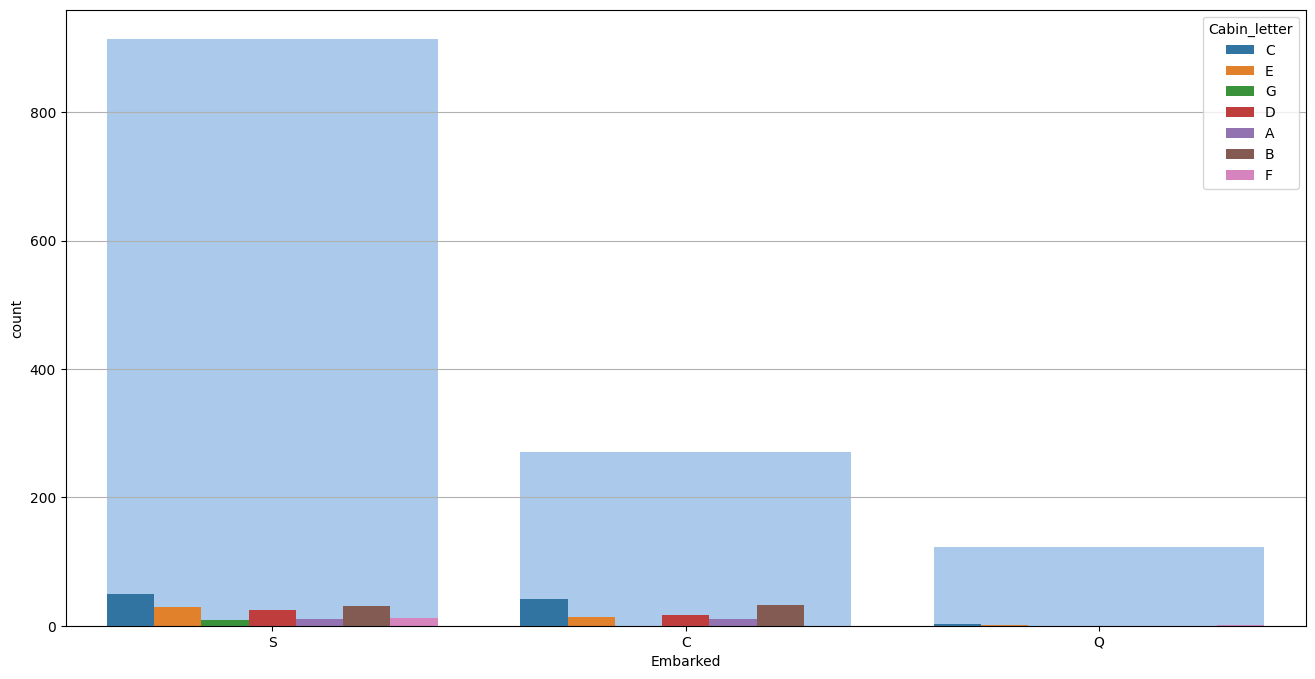

In [17]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Embarked', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Embarked', hue='Cabin_letter')

<Axes: xlabel='Embarked', ylabel='count'>

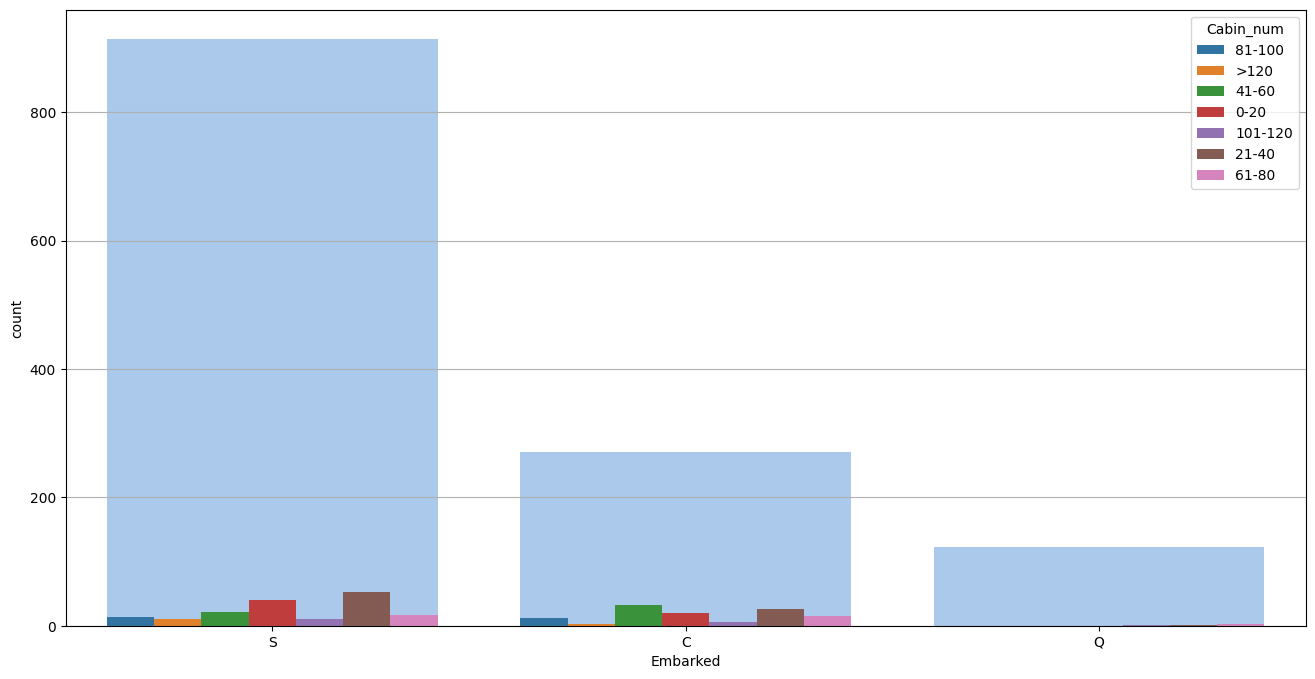

In [18]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Embarked', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Embarked', hue='Cabin_num')

### Family

<Axes: xlabel='Family', ylabel='count'>

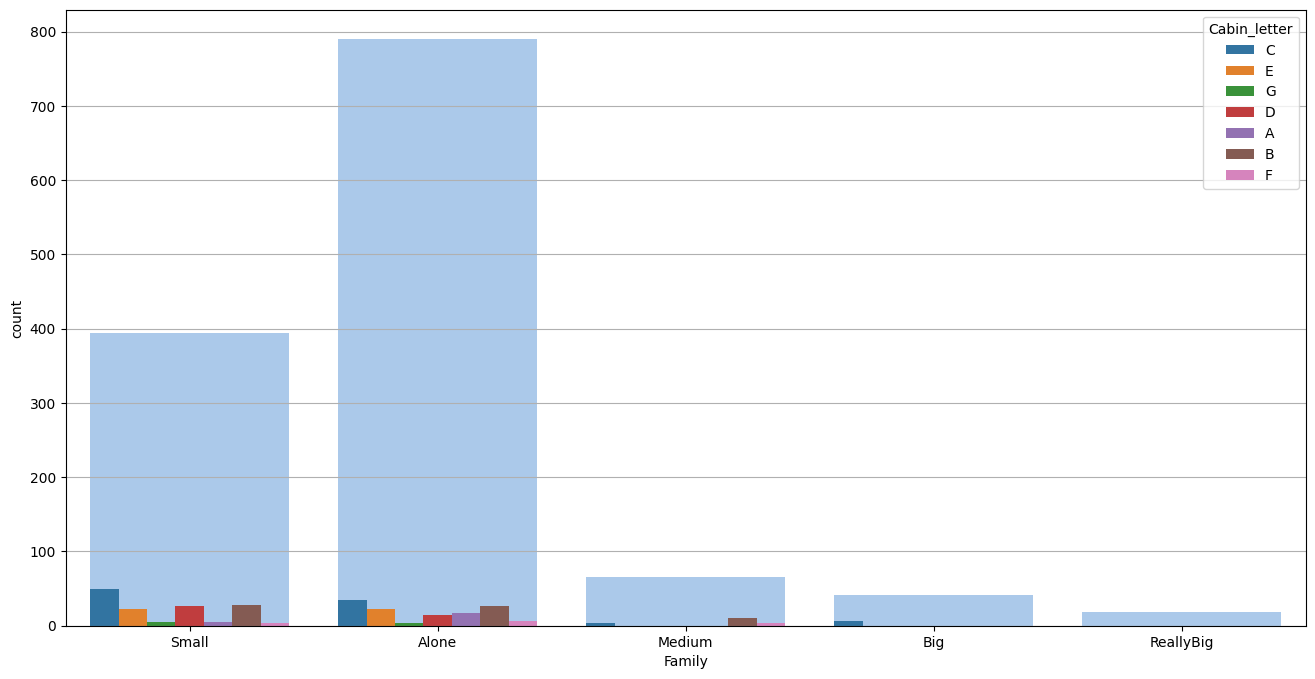

In [19]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Family', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Family', hue='Cabin_letter')

<Axes: xlabel='Family', ylabel='count'>

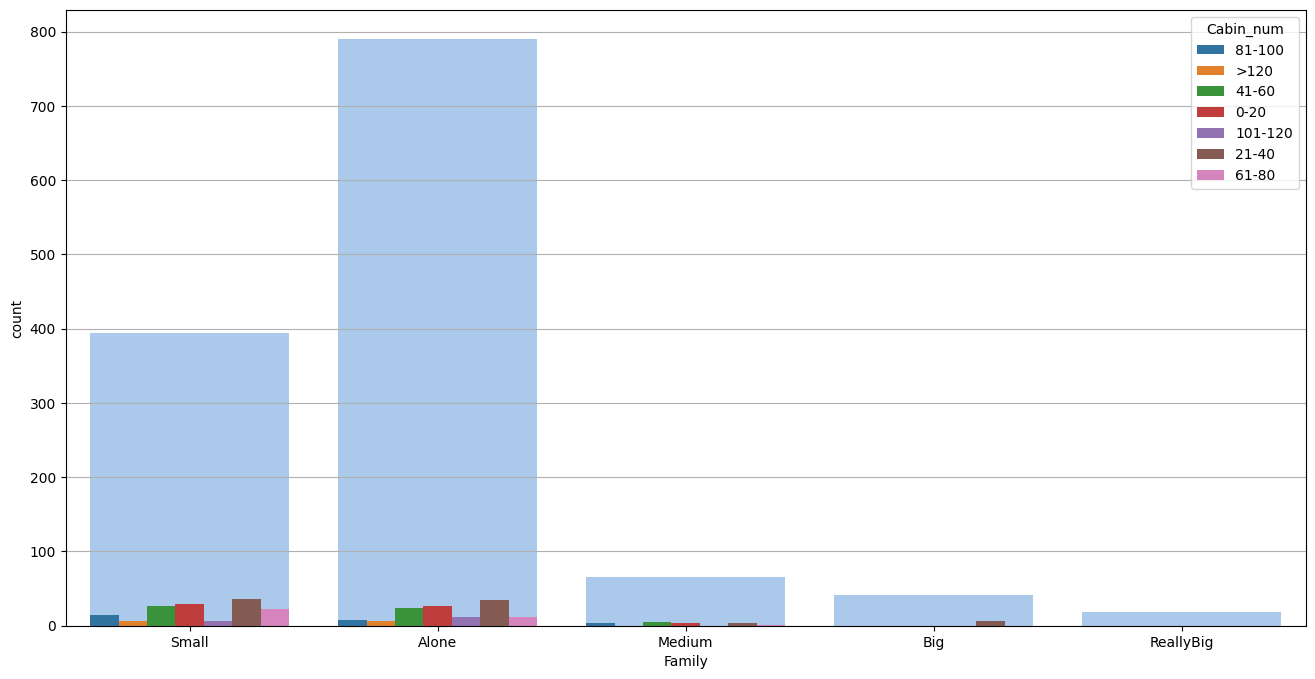

In [20]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Family', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Family', hue='Cabin_num')

# Decks

## Imputing 1

In [21]:
A_index = []
B_index = []
C_index = []
D_index = []
E_index = []
F_index = []
G_index = []

def restore_cabin():
    
    '''
 This function is going to iterate for each value in the selected features, then select the value with the highest count in Cabin_letter
 for each conbination and finally save the index of the null values in their respective list 
    '''
    for pclass in X['Pclass'].unique():
        for sex in X['Sex'].unique():
            for age in X['Age'].unique():
                for fare in X['Fare'].unique():
                    for embark in X['Embarked'].unique():
                        for family in X['Family'].unique():
                            df = X.loc[(X['Pclass'] == pclass) & 
                                  (X['Sex'] == sex) & 
                                  (X['Age'] == age) & 
                                  (X['Fare'] == fare) &
                                  (X['Family'] == family) &    
                                  (X['Embarked'] == embark)
                                  ]['Cabin_letter']
                            if len(df.value_counts().index) > 0 and len(df.loc[df.isnull()]) > 0:
                                letter = df.value_counts().index[0]
                                if letter == 'A':
                                    A_index.append([index for index in df.loc[df.isnull()].index])
                                elif letter == 'B':
                                    B_index.append([index for index in df.loc[df.isnull()].index])
                                elif letter == 'C':
                                    C_index.append([index for index in df.loc[df.isnull()].index])
                                elif letter == 'D':
                                    D_index.append([index for index in df.loc[df.isnull()].index])
                                elif letter == 'E':
                                    E_index.append([index for index in df.loc[df.isnull()].index])                            
                                elif letter == 'F':
                                    F_index.append([index for index in df.loc[df.isnull()].index])
                                elif letter == 'G':
                                    G_index.append([index for index in df.loc[df.isnull()].index])                               
restore_cabin()

In [22]:
#After using the function, the lists are going to have lists inside them so it's necessary to simplify them into a single list

A = []
B = []
C = []
D = []
E = []
F = []
G = []

for lists in A_index:
    for n in lists:
        A.append(n)
for lists in B_index:
    for n in lists:
        B.append(n)
for lists in C_index:
    for n in lists:
        C.append(n)
for lists in D_index:
    for n in lists:
        D.append(n)
for lists in E_index:
    for n in lists:
        E.append(n)
for lists in F_index:
    for n in lists:
        F.append(n)
for lists in G_index:
    for n in lists:
        G.append(n)

Now that we have the index of the null values for each deck letter, it's just a matter of locate them and replace the Cabin_letter value

Notice for each letter, the values of other columns are pretty similar or remain consistent in most of cases

In [23]:
X.loc[A]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
84,1,mr,male,YoungAdult,113059,high_fare,NaN,S,None,NaN,Alone
1190,1,mr,male,YoungAdult,113801,high_fare,NaN,S,None,NaN,Alone
31,1,None,male,Adult,PC 17601,high_medium_fare,NaN,C,None,NaN,Alone
605,1,mr,male,Adult,111426,high_medium_fare,NaN,C,None,NaN,Alone
494,1,mr,male,Elder,PC 17609,high_fare,NaN,C,None,NaN,Alone
843,1,miss,female,YoungAdult,113798,high_medium_fare,NaN,C,None,NaN,Alone


In [24]:
X.loc[A, 'Cabin_letter'] = 'A'

In [25]:
X.loc[B]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
374,1,mr,male,YoungAdult,PC 17760,extreme_fare,NaN,C,None,NaN,Alone
823,1,jonkheer,male,Adult,19972,low_fare,NaN,S,None,NaN,Alone
1219,1,mr,male,Adult,PC 17585,extreme_fare,NaN,C,None,NaN,Alone
1294,1,miss,female,YoungAdult,112378,high_fare,NaN,C,None,NaN,Small
1123,1,miss,female,YoungAdult,113795,high_medium_fare,NaN,S,None,NaN,Alone
291,1,miss,female,YoungAdult,19877,extreme_fare,NaN,S,None,NaN,Alone
709,1,miss,female,YoungAdult,113781,extreme_fare,NaN,S,None,NaN,Alone
1033,1,miss,female,YoungAdult,113781,extreme_fare,NaN,S,None,NaN,Alone


In [26]:
X.loc[B, 'Cabin_letter'] = 'B'

In [27]:
X.loc[C]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
448,1,mr,male,YoungAdult,113794,high_medium_fare,NaN,S,None,NaN,Alone
608,1,mr,male,YoungAdult,113804,high_medium_fare,NaN,S,None,NaN,Alone
1215,1,mr,male,YoungAdult,113790,high_medium_fare,NaN,S,None,NaN,Alone
986,1,mr,male,YoungAdult,13905,high_medium_fare,NaN,C,None,NaN,Alone
35,1,mr,male,YoungAdult,PC 17604,extreme_fare,NaN,C,None,NaN,Small
156,1,mr,male,Adult,PC 17597,high_fare,NaN,C,None,NaN,Small
912,1,mr,male,Adult,PC 17603,high_fare,NaN,C,None,NaN,Small
661,1,dr,male,Adult,PC 17611,extreme_fare,NaN,S,None,NaN,Small
1109,1,mr,male,Adult,36928,extreme_fare,NaN,S,None,NaN,Small


In [28]:
X.loc[C, 'Cabin_letter'] = 'C'

In [29]:
X.loc[D]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
915,1,mr,male,YoungAdult,PC 17597,high_fare,NaN,C,None,NaN,Small
36,1,mr,male,Adult,113789,high_fare,NaN,S,None,NaN,Small
538,1,miss,female,YoungAdult,PC 17761,extreme_fare,NaN,C,None,NaN,Alone
71,2,mr,male,YoungAdult,C.A. 33111,low_medium_fare,NaN,S,None,NaN,Alone
135,2,mr,male,YoungAdult,C.A. 29178,low_medium_fare,NaN,S,None,NaN,Alone
145,2,mr,male,YoungAdult,231945,low_medium_fare,NaN,S,None,NaN,Alone
179,2,mr,male,YoungAdult,250653,low_medium_fare,NaN,S,None,NaN,Alone
192,2,mr,male,YoungAdult,28424,low_medium_fare,NaN,S,None,NaN,Alone
214,2,mr,male,YoungAdult,250646,low_medium_fare,NaN,S,None,NaN,Alone


In [30]:
X.loc[D, 'Cabin_letter'] = 'D'

In [31]:
X.loc[E]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
58,3,mr,male,YoungAdult,2697,low_fare,NaN,C,None,NaN,Alone
61,3,mr,male,YoungAdult,2669,low_fare,NaN,C,None,NaN,Alone
131,3,mr,male,YoungAdult,349241,low_fare,NaN,C,None,NaN,Alone
245,3,mr,male,YoungAdult,2694,low_fare,NaN,C,None,NaN,Alone
297,3,mr,male,YoungAdult,2693,low_fare,NaN,C,None,NaN,Alone
...,...,...,...,...,...,...,...,...,...,...,...
388,2,miss,female,Adult,27849,low_medium_fare,NaN,S,None,NaN,Alone
459,2,miss,female,Adult,F.C.C. 13531,low_medium_fare,NaN,S,None,NaN,Alone
527,2,miss,female,Adult,W./C. 14258,low_medium_fare,NaN,S,None,NaN,Alone


In [32]:
X.loc[E, 'Cabin_letter'] = 'E'

In [33]:
X.loc[F]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
218,2,mr,male,Adult,243847,high_medium_fare,NaN,S,None,NaN,Small
237,2,mr,male,Adult,26707,high_medium_fare,NaN,S,None,NaN,Small
250,2,rev,male,Adult,244252,high_medium_fare,NaN,S,None,NaN,Small
315,2,mr,male,Adult,F.C.C. 13529,high_medium_fare,NaN,S,None,NaN,Small
595,2,mr,male,Adult,SC/AH 29037,high_medium_fare,NaN,S,None,NaN,Small
922,2,mr,male,Adult,SC/AH 3085,high_medium_fare,NaN,S,None,NaN,Small
1169,2,mr,male,Adult,2926,high_medium_fare,NaN,S,None,NaN,Small
1194,2,mr,male,Adult,S.O./P.P. 2,high_medium_fare,NaN,S,None,NaN,Small
1293,2,mr,male,Adult,28664,high_medium_fare,NaN,S,None,NaN,Small


In [34]:
X.loc[F, 'Cabin_letter'] = 'F'

In [35]:
X.loc[G]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
52,3,mr,male,YoungAdult,A/4. 39886,low_fare,NaN,S,None,NaN,Alone
92,3,mr,male,YoungAdult,347466,low_fare,NaN,S,None,NaN,Alone
106,3,mr,male,YoungAdult,349207,low_fare,NaN,S,None,NaN,Alone
128,3,mr,male,YoungAdult,C 17369,low_fare,NaN,S,None,NaN,Alone
132,3,mr,male,YoungAdult,SOTON/O.Q. 3101307,low_fare,NaN,S,None,NaN,Alone
...,...,...,...,...,...,...,...,...,...,...,...
480,3,miss,female,EarlyChild,3101298,low_medium_fare,NaN,S,None,NaN,Small
1155,3,miss,female,EarlyChild,350405,low_medium_fare,NaN,S,None,NaN,Small
1301,3,miss,female,EarlyChild,SOTON/O.Q. 3101315,low_medium_fare,NaN,S,None,NaN,Small


In [36]:
X.loc[G, 'Cabin_letter'] = 'G'

A good amount of Cabin_letter null values have been imputed, however because of the amount of features used to stablish similarity the combinations were too specific and didn't cover all of the null values

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Pclass        1309 non-null   int64 
 1   Name          1308 non-null   object
 2   Sex           1309 non-null   object
 3   Age           1039 non-null   object
 4   Ticket        1309 non-null   object
 5   Fare          1309 non-null   object
 6   Cabin         295 non-null    object
 7   Embarked      1307 non-null   object
 8   Cabin_letter  633 non-null    object
 9   Cabin_num     289 non-null    object
 10  Family        1309 non-null   object
dtypes: int64(1), object(10)
memory usage: 155.0+ KB


## Imputing 2

In [38]:
A_index = []
B_index = []
C_index = []
D_index = []
E_index = []
F_index = []
G_index = []

def restore_cabin():
    '''
This function is just like the anterior one but it considers less columns to make 
a simpler similarity correlation
'''
    for pclass in X['Pclass'].unique():
        for age in X['Age'].unique():
            for fare in X['Fare'].unique():
                for sex in X['Sex'].unique():
                    df = X.loc[(X['Pclass'] == pclass) & 
                          (X['Age'] == age) & 
                          (X['Fare'] == fare) & 
                          (X['Sex'] == sex)
                          ]['Cabin_letter']
                    if len(df.value_counts().index) > 0 and len(df.loc[df.isnull()]) > 0:
                        letter = df.value_counts().index[0]
                        if letter == 'A':
                            A_index.append([index for index in df.loc[df.isnull()].index])
                        elif letter == 'B':
                            B_index.append([index for index in df.loc[df.isnull()].index])
                        elif letter == 'C':
                            C_index.append([index for index in df.loc[df.isnull()].index])
                        elif letter == 'D':
                            D_index.append([index for index in df.loc[df.isnull()].index])
                        elif letter == 'E':
                            E_index.append([index for index in df.loc[df.isnull()].index])                            
                        elif letter == 'F':
                            F_index.append([index for index in df.loc[df.isnull()].index])
                        elif letter == 'G':
                            G_index.append([index for index in df.loc[df.isnull()].index])                               
restore_cabin()

In [39]:
A = []
B = []
C = []
D = []
E = []
F = []
G = []

for lists in A_index:
    for n in lists:
        A.append(n)
for lists in B_index:
    for n in lists:
        B.append(n)
for lists in C_index:
    for n in lists:
        C.append(n)
for lists in D_index:
    for n in lists:
        D.append(n)
for lists in E_index:
    for n in lists:
        E.append(n)
for lists in F_index:
    for n in lists:
        F.append(n)
for lists in G_index:
    for n in lists:
        G.append(n)

The first 3 Decks don't have new rows, so we determine that all of the high socio-economial status passengers have been already asigned to one Deck

In [40]:
X.loc[A]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,


In [41]:
X.loc[B]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,


In [42]:
X.loc[C]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,


In [43]:
X.loc[D]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
530,2,mr,male,YoungAdult,29104,low_medium_fare,NaN,S,None,NaN,Medium
862,2,mr,male,YoungAdult,28134,low_medium_fare,NaN,S,None,NaN,Small
1262,2,mr,male,YoungAdult,28133,low_medium_fare,NaN,S,None,NaN,Small
1298,2,mr,male,YoungAdult,28666,low_medium_fare,NaN,S,None,NaN,Small


In [44]:
X.loc[D, 'Cabin_letter'] = 'D'

In [45]:
X.loc[E]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
70,3,mr,male,YoungAdult,315151,low_medium_fare,NaN,S,None,NaN,Small
74,3,mr,male,YoungAdult,2680,low_medium_fare,NaN,C,None,NaN,Small
286,3,mr,male,YoungAdult,349239,low_medium_fare,NaN,C,None,NaN,Alone
393,3,mr,male,YoungAdult,3101277,low_medium_fare,NaN,S,None,NaN,Small
617,3,mr,male,YoungAdult,347080,low_medium_fare,NaN,S,None,NaN,Small
621,3,mr,male,YoungAdult,2659,low_medium_fare,NaN,C,None,NaN,Small
665,3,mr,male,YoungAdult,STON/O 2. 3101285,low_medium_fare,NaN,S,None,NaN,Small
1007,3,mr,male,YoungAdult,2680,low_medium_fare,NaN,C,None,NaN,Small
1064,3,mr,male,YoungAdult,347072,low_medium_fare,NaN,S,None,NaN,Small


In [46]:
X.loc[E, 'Cabin_letter'] = 'E'

In [47]:
X.loc[F]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
323,2,miss,female,YoungAdult,234818,low_medium_fare,NaN,Q,None,NaN,Alone
418,2,miss,female,YoungAdult,250652,low_medium_fare,NaN,S,None,NaN,Small
474,2,mrs,female,YoungAdult,SC/AH Basle 541,low_medium_fare,D,C,None,NaN,Alone
867,2,miss,female,YoungAdult,SC/PARIS 2149,low_medium_fare,NaN,C,None,NaN,Small
1112,2,miss,female,YoungAdult,SC/PARIS 2148,low_medium_fare,NaN,C,None,NaN,Small
1130,2,miss,female,YoungAdult,250650,low_medium_fare,NaN,S,None,NaN,Small
671,2,mrs,female,Adult,29750,high_fare,NaN,S,None,NaN,Small
1222,2,mrs,female,Adult,C.A. 33112,high_fare,NaN,S,None,NaN,Small
21,2,mr,male,Adult,239865,high_medium_fare,NaN,S,None,NaN,Alone


In [48]:
X.loc[F, 'Cabin_letter'] = 'F'

In [49]:
X.loc[G]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
1,3,mr,male,YoungAdult,A/5 21171,low_fare,NaN,S,None,NaN,Small
144,3,mr,male,YoungAdult,365222,low_fare,NaN,Q,None,NaN,Alone
176,3,mr,male,YoungAdult,350404,low_fare,NaN,S,None,NaN,Small
268,3,mr,male,YoungAdult,347083,low_fare,NaN,S,None,NaN,Small
372,3,mr,male,YoungAdult,3101267,low_fare,NaN,S,None,NaN,Small
422,3,mr,male,YoungAdult,A/5. 13032,low_fare,NaN,Q,None,NaN,Alone
443,3,mr,male,YoungAdult,347076,low_fare,NaN,S,None,NaN,Small
478,3,mr,male,YoungAdult,3460,low_fare,NaN,S,None,NaN,Small
511,3,mr,male,YoungAdult,382651,low_fare,NaN,Q,None,NaN,Alone


In [50]:
X.loc[G, 'Cabin_letter'] = 'G'

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Pclass        1309 non-null   int64 
 1   Name          1308 non-null   object
 2   Sex           1309 non-null   object
 3   Age           1039 non-null   object
 4   Ticket        1309 non-null   object
 5   Fare          1309 non-null   object
 6   Cabin         295 non-null    object
 7   Embarked      1307 non-null   object
 8   Cabin_letter  725 non-null    object
 9   Cabin_num     289 non-null    object
 10  Family        1309 non-null   object
dtypes: int64(1), object(10)
memory usage: 155.0+ KB


## Imputing 3

In [52]:
D_index = []
E_index = []
F_index = []
G_index = []

# Same process but with less columns and decks
def restore_cabin():
    for pclass in X['Pclass'].unique():
            for fare in X['Fare'].unique():
                df = X.loc[(X['Pclass'] == pclass) & 
                      (X['Fare'] == fare)
                      ]['Cabin_letter']
                if len(df.value_counts().index) > 0 and len(df.loc[df.isnull()]) > 0:
                    letter = df.value_counts().index[0]
                    if letter == 'D':
                        D_index.append([index for index in df.loc[df.isnull()].index])
                    elif letter == 'E':
                        E_index.append([index for index in df.loc[df.isnull()].index])                            
                    elif letter == 'F':
                        F_index.append([index for index in df.loc[df.isnull()].index])
                    elif letter == 'G':
                        G_index.append([index for index in df.loc[df.isnull()].index])                               
restore_cabin()

In [53]:
D = []
E = []
F = []
G = []

for lists in D_index:
    for n in lists:
        D.append(n)
for lists in E_index:
    for n in lists:
        E.append(n)
for lists in F_index:
    for n in lists:
        F.append(n)
for lists in G_index:
    for n in lists:
        G.append(n)

In [54]:
X.loc[D]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
18,2,mr,male,None,244373,low_medium_fare,NaN,S,None,NaN,Alone
34,2,mr,male,Elder,C.A. 24579,low_medium_fare,NaN,S,None,NaN,Alone
85,2,miss,female,Teen,SO/C 14885,low_medium_fare,NaN,S,None,NaN,Alone
150,2,rev,male,Adult,244310,low_medium_fare,NaN,S,None,NaN,Alone
151,2,rev,male,Adult,S.O.P. 1166,low_medium_fare,NaN,S,None,NaN,Alone
233,2,mr,male,Adult,237442,low_medium_fare,NaN,S,None,NaN,Alone
266,2,mr,male,Adult,C.A. 17248,low_medium_fare,NaN,S,None,NaN,Alone
289,2,mr,male,Adult,237798,low_medium_fare,NaN,S,None,NaN,Alone
293,2,mr,male,Adult,SC/Paris 2163,low_medium_fare,D,C,None,NaN,Alone


In [55]:
X.loc[D, 'Cabin_letter'] = 'D'

In [56]:
X.loc[E]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
5,3,mr,male,Adult,373450,low_medium_fare,NaN,S,None,NaN,Alone
6,3,mr,male,None,330877,low_medium_fare,NaN,Q,None,NaN,Alone
23,3,miss,female,Teen,330923,low_medium_fare,NaN,Q,None,NaN,Alone
40,3,miss,female,Teen,2651,low_medium_fare,NaN,C,None,NaN,Small
41,3,mrs,female,Adult,7546,low_medium_fare,NaN,S,None,NaN,Small
...,...,...,...,...,...,...,...,...,...,...,...
1186,3,mr,male,Adult,345771,low_medium_fare,NaN,S,None,NaN,Alone
1199,3,master,male,EarlyChild,392091,low_medium_fare,NaN,S,None,NaN,Small
1201,3,mrs,female,Adult,350026,low_medium_fare,NaN,S,None,NaN,Small


In [57]:
X.loc[E, 'Cabin_letter'] = 'E'

In [58]:
X.loc[F]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
73,2,mr,male,YoungAdult,S.O.C. 14879,high_fare,NaN,S,None,NaN,Alone
121,2,mr,male,YoungAdult,S.O.C. 14879,high_fare,NaN,S,None,NaN,Small
146,2,mr,male,YoungAdult,C.A. 33112,high_fare,NaN,S,None,NaN,Small
386,2,mr,male,YoungAdult,S.O.C. 14879,high_fare,NaN,S,None,NaN,Alone
417,2,mrs,female,YoungAdult,28220,high_fare,NaN,S,None,NaN,Small
...,...,...,...,...,...,...,...,...,...,...,...
1170,2,mr,male,YoungAdult,CA 31352,high_medium_fare,NaN,S,None,NaN,Small
1193,2,mr,male,None,237735,high_medium_fare,D,C,None,NaN,Alone
1220,2,mr,male,YoungAdult,2003,high_medium_fare,NaN,S,None,NaN,Small


In [59]:
X.loc[F, 'Cabin_letter'] = 'F'

In [60]:
X.loc[G]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
15,3,miss,female,Teen,350406,low_fare,NaN,S,None,NaN,Alone
20,3,mrs,female,None,2649,low_fare,NaN,C,None,NaN,Alone
27,3,mr,male,None,2631,low_fare,NaN,C,None,NaN,Alone
29,3,miss,female,None,330959,low_fare,NaN,Q,None,NaN,Alone
30,3,mr,male,None,349216,low_fare,NaN,S,None,NaN,Alone
...,...,...,...,...,...,...,...,...,...,...,...
1274,3,mrs,female,None,364498,high_medium_fare,NaN,S,None,NaN,Alone
1281,3,master,male,Childhood,349909,high_medium_fare,NaN,S,None,NaN,Medium
1284,3,master,male,Teen,C.A. 2673,high_medium_fare,NaN,S,None,NaN,Small


In [61]:
X.loc[G, 'Cabin_letter'] = 'G'

In [62]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Pclass        1309 non-null   int64 
 1   Name          1308 non-null   object
 2   Sex           1309 non-null   object
 3   Age           1039 non-null   object
 4   Ticket        1309 non-null   object
 5   Fare          1309 non-null   object
 6   Cabin         295 non-null    object
 7   Embarked      1307 non-null   object
 8   Cabin_letter  1226 non-null   object
 9   Cabin_num     289 non-null    object
 10  Family        1309 non-null   object
dtypes: int64(1), object(10)
memory usage: 155.0+ KB


## Imputing 4

In [63]:
D_index = []
E_index = []
F_index = []
G_index = []

def restore_cabin():
        for fare in X['Fare'].unique():
            df = X.loc[
                  (X['Fare'] == fare)
                  ]['Cabin_letter']
            if len(df.value_counts().index) > 0 and len(df.loc[df.isnull()]) > 0:
                letter = df.value_counts().index[0]
                if letter == 'D':
                    D_index.append([index for index in df.loc[df.isnull()].index])
                elif letter == 'E':
                    E_index.append([index for index in df.loc[df.isnull()].index])                            
                elif letter == 'F':
                    F_index.append([index for index in df.loc[df.isnull()].index])
                elif letter == 'G':
                    G_index.append([index for index in df.loc[df.isnull()].index])                               
restore_cabin()

In [64]:
D = []
E = []
F = []
G = []

for lists in D_index:
    for n in lists:
        D.append(n)
for lists in E_index:
    for n in lists:
        E.append(n)
for lists in F_index:
    for n in lists:
        F.append(n)
for lists in G_index:
    for n in lists:
        G.append(n)

In [65]:
X.loc[D]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,


In [66]:
X.loc[E]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,


In [67]:
X.loc[F]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
14,3,mr,male,Adult,347082,high_fare,NaN,S,None,NaN,Big
26,3,mrs,female,Adult,347077,high_fare,NaN,S,None,NaN,Big
51,3,master,male,Childhood,3101295,high_fare,NaN,S,None,NaN,Big
60,3,master,male,Childhood,CA 2144,high_fare,NaN,S,None,NaN,ReallyBig
72,3,miss,female,Teen,CA 2144,high_fare,NaN,S,None,NaN,ReallyBig
75,3,mr,male,YoungAdult,1601,high_fare,NaN,S,None,NaN,Alone
87,3,mr,male,Teen,W./C. 6608,high_fare,NaN,S,None,NaN,Medium
120,3,miss,female,EarlyChild,347082,high_fare,NaN,S,None,NaN,Big
148,3,miss,female,Childhood,W./C. 6608,high_fare,NaN,S,None,NaN,Medium


In [68]:
X.loc[F, 'Cabin_letter'] = 'F'

In [69]:
X.loc[G]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
278,2,mr,male,None,239853,low_fare,NaN,S,None,NaN,Alone
414,2,mr,male,None,239853,low_fare,NaN,S,None,NaN,Alone
467,2,mr,male,None,239853,low_fare,NaN,S,None,NaN,Alone
482,2,mr,male,None,239854,low_fare,NaN,S,None,NaN,Alone
634,1,mr,male,None,112052,low_fare,NaN,S,None,NaN,Alone
675,2,mr,male,None,239856,low_fare,NaN,S,None,NaN,Alone
733,2,mr,male,None,239855,low_fare,NaN,S,None,NaN,Alone
1158,1,mr,male,None,112051,low_fare,NaN,S,None,NaN,Alone
65,1,mr,male,None,PC 17605,high_medium_fare,NaN,C,None,NaN,Alone


There's only one null value left for the Cabin_letter, which is and old man with a really expensive third class ticket traveling by himself

In [70]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Pclass        1309 non-null   int64 
 1   Name          1308 non-null   object
 2   Sex           1309 non-null   object
 3   Age           1039 non-null   object
 4   Ticket        1309 non-null   object
 5   Fare          1309 non-null   object
 6   Cabin         295 non-null    object
 7   Embarked      1307 non-null   object
 8   Cabin_letter  1284 non-null   object
 9   Cabin_num     289 non-null    object
 10  Family        1309 non-null   object
dtypes: int64(1), object(10)
memory usage: 155.0+ KB


In [71]:
X.loc[X['Cabin_letter'].isnull() == True]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
65,1,mr,male,None,PC 17605,high_medium_fare,NaN,C,None,NaN,Alone
169,1,mr,male,None,PC 17318,high_medium_fare,NaN,S,None,NaN,Alone
257,1,mrs,female,None,PC 17585,extreme_fare,NaN,C,None,NaN,Alone
271,1,mr,male,None,113798,high_medium_fare,NaN,S,None,NaN,Alone
278,2,mr,male,None,239853,low_fare,NaN,S,None,NaN,Alone
296,1,mr,male,None,PC 17612,high_medium_fare,NaN,C,None,NaN,Alone
307,1,miss,female,None,17421,extreme_fare,NaN,C,None,NaN,Alone
335,1,mrs,female,None,PC 17611,extreme_fare,NaN,S,None,NaN,Small
376,1,mrs,female,None,PC 17604,extreme_fare,NaN,C,None,NaN,Small


In [72]:
X.loc[X['Cabin_letter'].isnull() == True, 'Cabin_letter'] = 'F'

### Visualization

Let's check how the other columns have changed now that all of the values have been imputed for Cabin_letter

#### Fare

<Axes: xlabel='Fare', ylabel='count'>

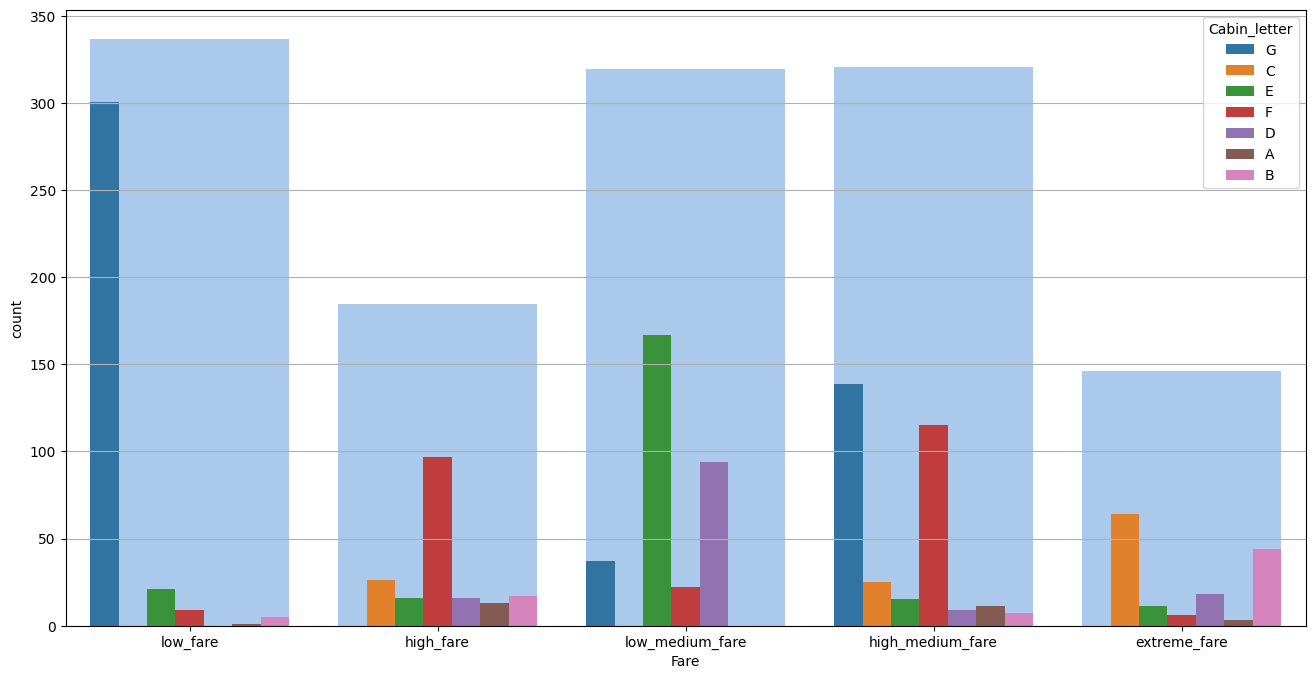

In [73]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Fare', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Fare', hue='Cabin_letter')

#### Pclass

<Axes: xlabel='Pclass', ylabel='count'>

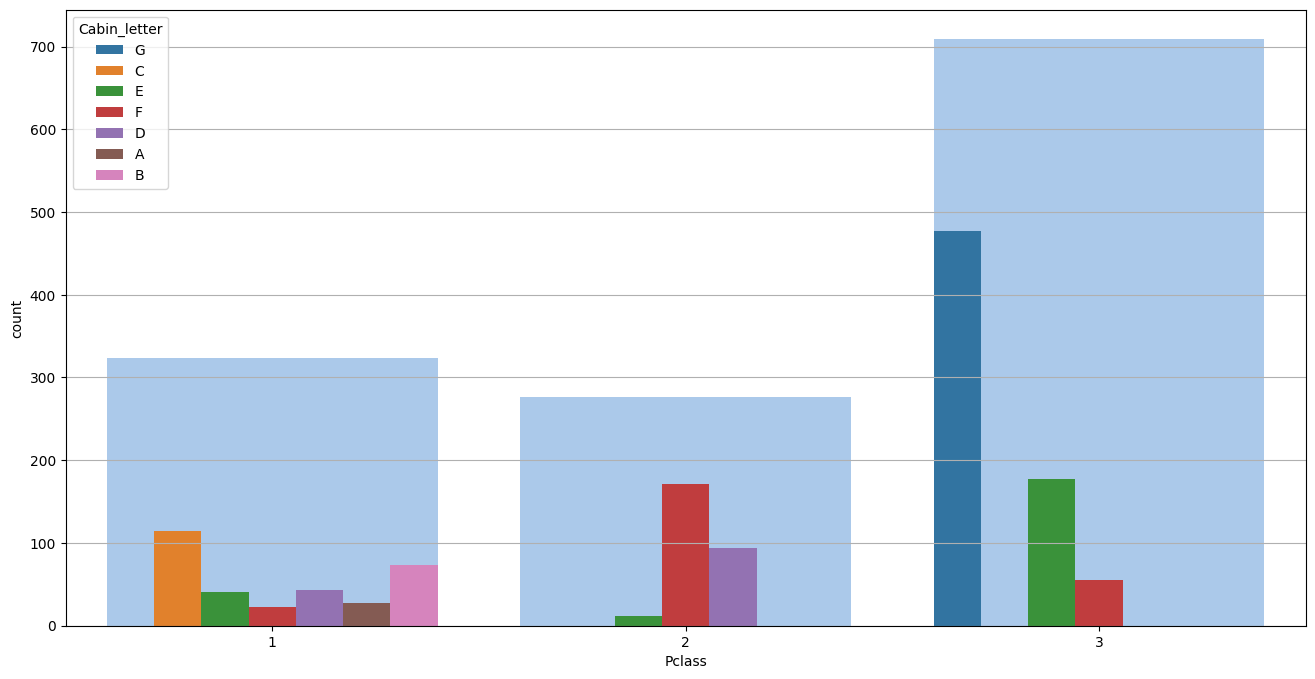

In [74]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Pclass', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Pclass', hue='Cabin_letter')

#### Sex

<Axes: xlabel='Sex', ylabel='count'>

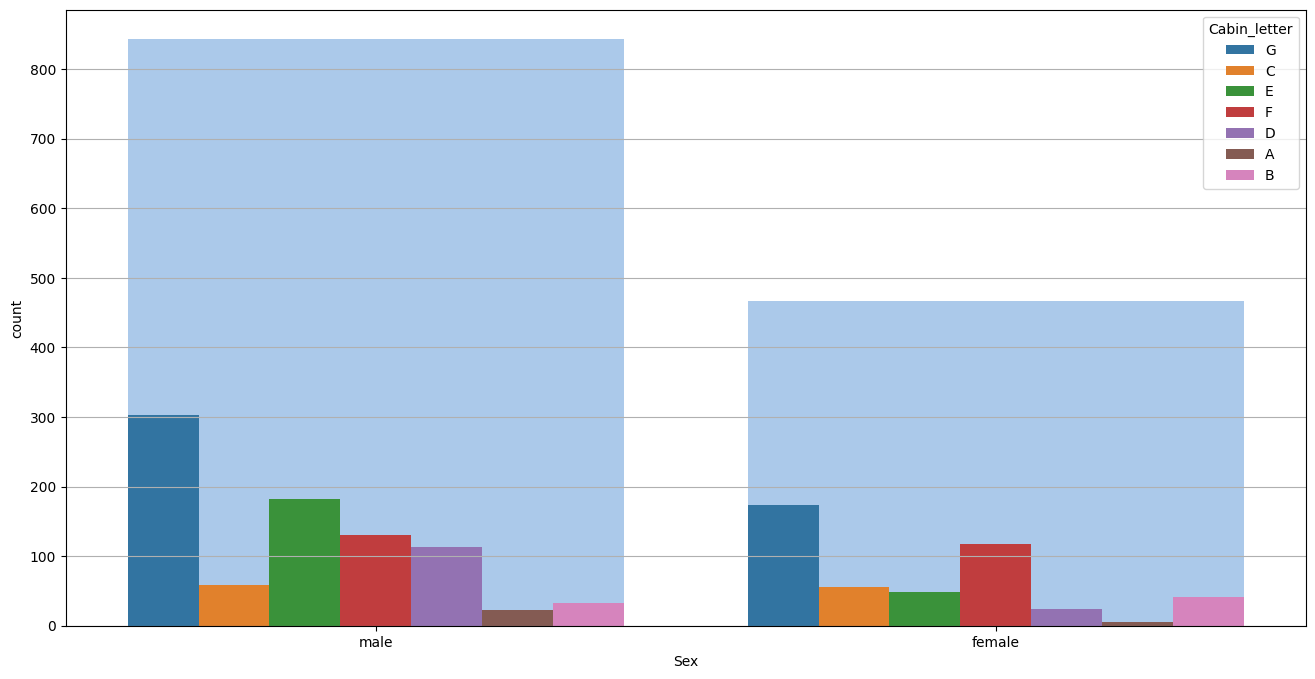

In [75]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Sex', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Sex', hue='Cabin_letter')

#### Age

<Axes: xlabel='Age', ylabel='count'>

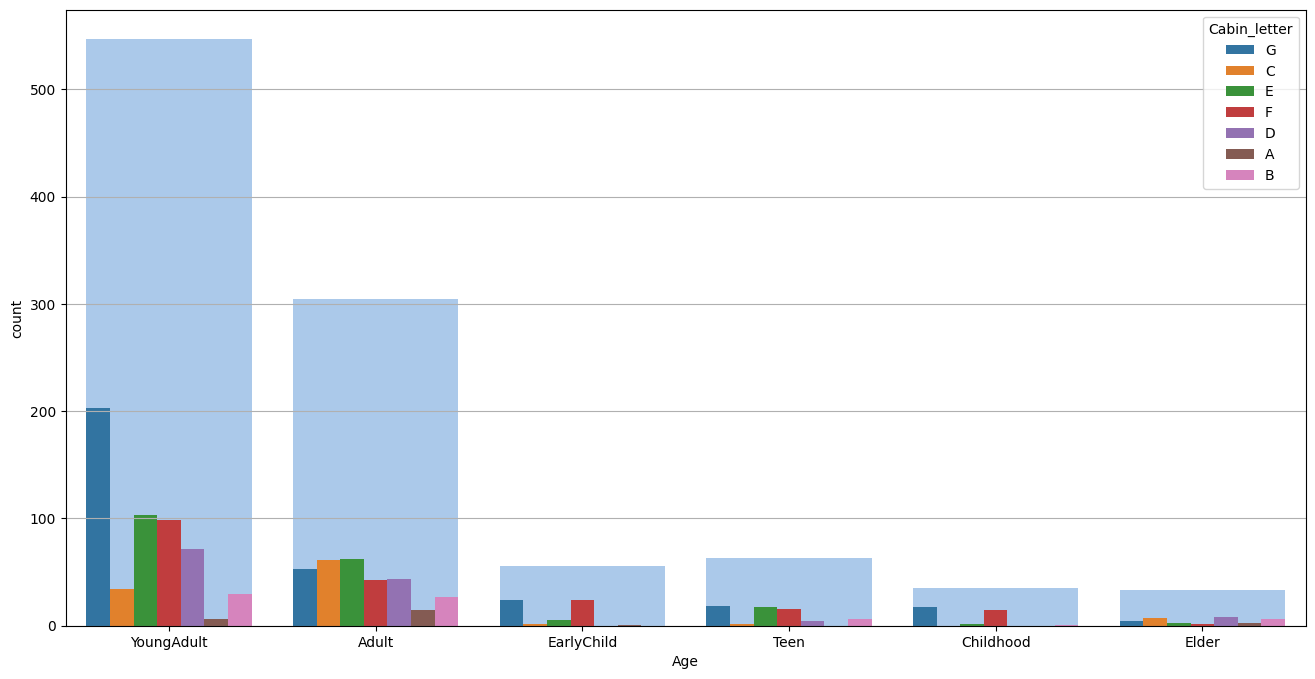

In [76]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Age', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Age', hue='Cabin_letter')

#### Embarked

<Axes: xlabel='Embarked', ylabel='count'>

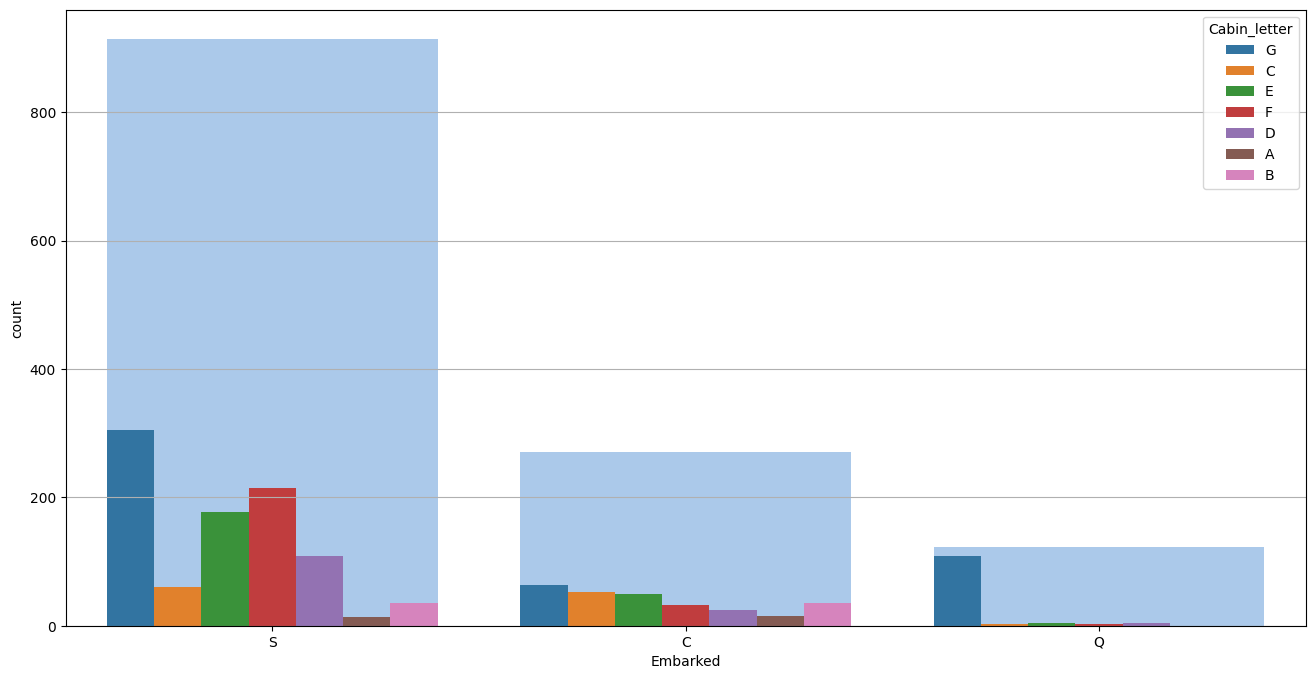

In [77]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Embarked', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Embarked', hue='Cabin_letter')

#### Family

<Axes: xlabel='Family', ylabel='count'>

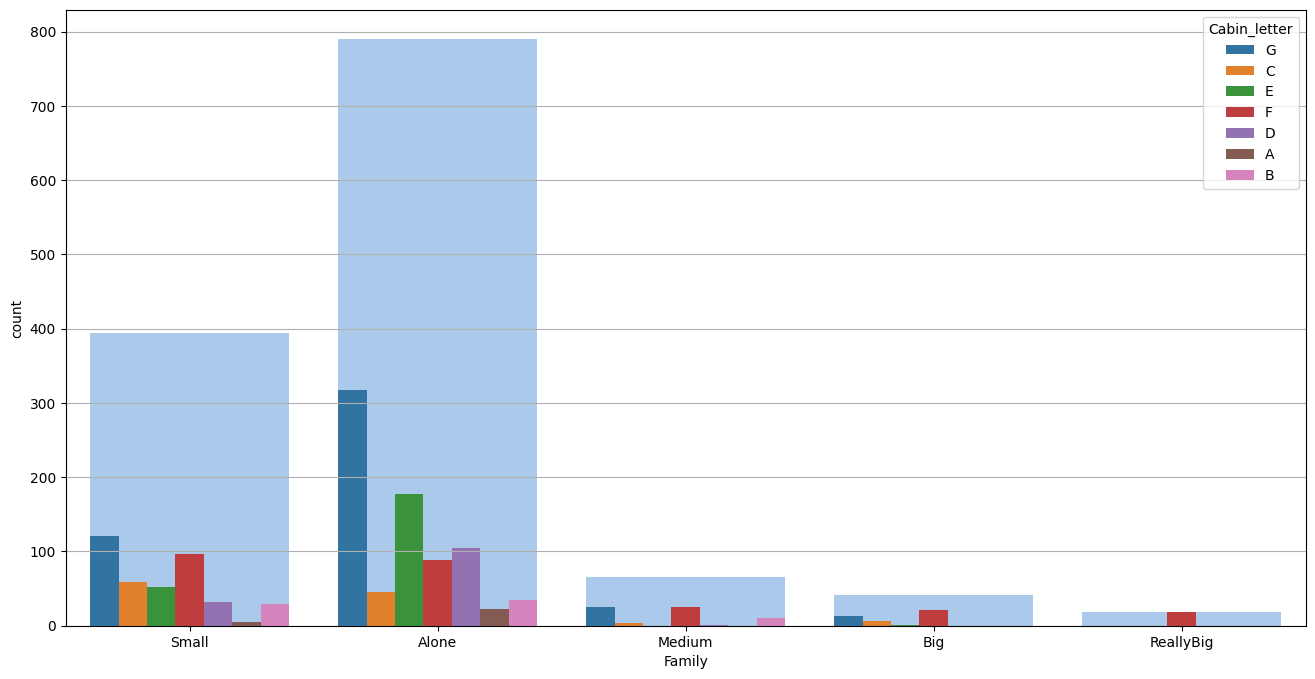

In [78]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Family', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Family', hue='Cabin_letter')

# Number

## Imputing 1

In [79]:
n0_20_index = []
n21_40_index = []
n41_60_index = []
n61_80_index = []
n81_100_index = []
n101_120_index = []
n120_index = []

#The same process for de Cabin_letter is going to be applied to the Cabin_num

def restore_cabin():
    for pclass in X['Pclass'].unique():
        for sex in X['Sex'].unique():
            for age in X['Age'].unique():
                for fare in X['Fare'].unique():
                    for embark in X['Embarked'].unique():
                        for family in X['Family'].unique():
                            df = X.loc[(X['Pclass'] == pclass) & 
                                  (X['Sex'] == sex) & 
                                  (X['Age'] == age) & 
                                  (X['Fare'] == fare) & 
                                  (X['Family'] == family) &
                                  (X['Embarked'] == embark)
                                  ]['Cabin_num']
                            if len(df.value_counts().index) > 0 and len(df.loc[df.isnull()]) > 0:
                                num = df.value_counts().index[0]
                                if num == '0-20':
                                    n0_20_index.append([index for index in df.loc[df.isnull()].index])
                                elif num == '21-40':
                                    n21_40_index.append([index for index in df.loc[df.isnull()].index])
                                elif num == '41-60':
                                    n41_60_index.append([index for index in df.loc[df.isnull()].index])
                                elif num == '61-80':
                                    n61_80_index.append([index for index in df.loc[df.isnull()].index])
                                elif num == '81-100':
                                    n81_100_index.append([index for index in df.loc[df.isnull()].index])                            
                                elif num == '101-120':
                                    n101_120_index.append([index for index in df.loc[df.isnull()].index])
                                elif num == '>120':
                                    n120_index.append([index for index in df.loc[df.isnull()].index])                               
restore_cabin()

In [80]:
n0_20 = []
n21_40 = []
n41_60 = []
n61_80 = []
n81_100 = []
n101_120 = []
n120 = []

for lists in n0_20_index:
    for n in lists:
        n0_20.append(n)
for lists in n21_40_index:
    for n in lists:
        n21_40.append(n)
for lists in n41_60_index:
    for n in lists:
        n41_60.append(n)
for lists in n61_80_index:
    for n in lists:
        n61_80.append(n)
for lists in n81_100_index:
    for n in lists:
        n81_100.append(n)
for lists in n101_120_index:
    for n in lists:
        n101_120.append(n)
for lists in n120_index:
    for n in lists:
        n120.append(n)

In [81]:
X.loc[n0_20]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
13,3,mr,male,YoungAdult,A/5. 2151,low_medium_fare,NaN,S,E,NaN,Alone
38,3,mr,male,YoungAdult,A./5. 2152,low_medium_fare,NaN,S,E,NaN,Alone
68,3,mr,male,YoungAdult,S.P. 3464,low_medium_fare,NaN,S,E,NaN,Alone
81,3,mr,male,YoungAdult,345767,low_medium_fare,NaN,S,E,NaN,Alone
82,3,mr,male,YoungAdult,345779,low_medium_fare,NaN,S,E,NaN,Alone
...,...,...,...,...,...,...,...,...,...,...,...
408,2,master,male,EarlyChild,29106,high_medium_fare,NaN,S,F,NaN,Small
756,2,master,male,EarlyChild,250649,high_medium_fare,NaN,S,F,NaN,Small
832,2,master,male,EarlyChild,29106,high_medium_fare,NaN,S,F,NaN,Small


In [82]:
X.loc[n0_20, 'Cabin_num'] = '0-20'

In [83]:
X.loc[n21_40]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
36,1,mr,male,Adult,113789,high_fare,NaN,S,D,NaN,Small
188,1,mr,male,Adult,111428,high_medium_fare,NaN,S,E,NaN,Alone
468,1,mr,male,Adult,113792,high_medium_fare,NaN,S,E,NaN,Alone
903,1,mr,male,Adult,694,high_medium_fare,NaN,S,E,NaN,Alone
974,1,mr,male,Adult,19924,high_medium_fare,NaN,S,E,NaN,Alone
1036,1,mr,male,Adult,17475,high_medium_fare,NaN,S,E,NaN,Alone
546,1,mr,male,Elder,693,high_medium_fare,NaN,S,C,NaN,Alone
556,1,mr,male,Elder,113807,high_medium_fare,NaN,S,C,NaN,Alone
1294,1,miss,female,YoungAdult,112378,high_fare,NaN,C,B,NaN,Small


In [84]:
X.loc[n21_40, 'Cabin_num'] = '21-40'

In [85]:
X.loc[n41_60]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
58,3,mr,male,YoungAdult,2697,low_fare,NaN,C,E,NaN,Alone
61,3,mr,male,YoungAdult,2669,low_fare,NaN,C,E,NaN,Alone
131,3,mr,male,YoungAdult,349241,low_fare,NaN,C,E,NaN,Alone
245,3,mr,male,YoungAdult,2694,low_fare,NaN,C,E,NaN,Alone
297,3,mr,male,YoungAdult,2693,low_fare,NaN,C,E,NaN,Alone
...,...,...,...,...,...,...,...,...,...,...,...
1232,2,mr,male,YoungAdult,C.A. 15185,low_medium_fare,NaN,S,D,NaN,Alone
1238,2,mr,male,YoungAdult,237670,low_medium_fare,NaN,S,D,NaN,Alone
1240,2,mr,male,YoungAdult,248726,low_medium_fare,NaN,S,D,NaN,Alone


In [86]:
X.loc[n41_60, 'Cabin_num'] = '41-60'

In [87]:
X.loc[n61_80]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
52,3,mr,male,YoungAdult,A/4. 39886,low_fare,NaN,S,G,NaN,Alone
92,3,mr,male,YoungAdult,347466,low_fare,NaN,S,G,NaN,Alone
106,3,mr,male,YoungAdult,349207,low_fare,NaN,S,G,NaN,Alone
128,3,mr,male,YoungAdult,C 17369,low_fare,NaN,S,G,NaN,Alone
132,3,mr,male,YoungAdult,SOTON/O.Q. 3101307,low_fare,NaN,S,G,NaN,Alone
...,...,...,...,...,...,...,...,...,...,...,...
388,2,miss,female,Adult,27849,low_medium_fare,NaN,S,E,NaN,Alone
459,2,miss,female,Adult,F.C.C. 13531,low_medium_fare,NaN,S,E,NaN,Alone
527,2,miss,female,Adult,W./C. 14258,low_medium_fare,NaN,S,E,NaN,Alone


In [88]:
X.loc[n61_80, 'Cabin_num'] = '61-80'

In [89]:
X.loc[n81_100]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
374,1,mr,male,YoungAdult,PC 17760,extreme_fare,NaN,C,B,NaN,Alone
823,1,jonkheer,male,Adult,19972,low_fare,NaN,S,B,NaN,Alone
661,1,dr,male,Adult,PC 17611,extreme_fare,NaN,S,C,NaN,Small
1109,1,mr,male,Adult,36928,extreme_fare,NaN,S,C,NaN,Small
857,1,mrs,female,Adult,36928,extreme_fare,NaN,S,C,NaN,Small
1216,1,miss,female,Adult,24160,extreme_fare,NaN,S,C,NaN,Alone


In [90]:
X.loc[n81_100, 'Cabin_num'] = '81-100'

In [91]:
X.loc[n101_120]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,


In [92]:
X.loc[n120]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,


In [93]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Pclass        1309 non-null   int64 
 1   Name          1308 non-null   object
 2   Sex           1309 non-null   object
 3   Age           1039 non-null   object
 4   Ticket        1309 non-null   object
 5   Fare          1309 non-null   object
 6   Cabin         295 non-null    object
 7   Embarked      1307 non-null   object
 8   Cabin_letter  1309 non-null   object
 9   Cabin_num     633 non-null    object
 10  Family        1309 non-null   object
dtypes: int64(1), object(10)
memory usage: 155.0+ KB


## Imputing 2

In [94]:
n0_20_index = []
n21_40_index = []
n41_60_index = []
n61_80_index = []
n81_100_index = []

def restore_cabin():
    for pclass in X['Pclass'].unique():
        for sex in X['Sex'].unique():
            for age in X['Age'].unique():
                for fare in X['Fare'].unique():
                    df = X.loc[(X['Pclass'] == pclass) & 
                          (X['Sex'] == sex) & 
                          (X['Age'] == age) & 
                          (X['Fare'] == fare) 
                          ]['Cabin_num']
                    if len(df.value_counts().index) > 0 and len(df.loc[df.isnull()]) > 0:
                        num = df.value_counts().index[0]
                        if num == '0-20':
                            n0_20_index.append([index for index in df.loc[df.isnull()].index])
                        elif num == '21-40':
                            n21_40_index.append([index for index in df.loc[df.isnull()].index])
                        elif num == '41-60':
                            n41_60_index.append([index for index in df.loc[df.isnull()].index])
                        elif num == '61-80':
                            n61_80_index.append([index for index in df.loc[df.isnull()].index])
                        elif num == '81-100':
                            n81_100_index.append([index for index in df.loc[df.isnull()].index])                            
                             
restore_cabin()

In [95]:
n0_20 = []
n21_40 = []
n41_60 = []
n61_80 = []
n81_100 = []

for lists in n0_20_index:
    for n in lists:
        n0_20.append(n)
for lists in n21_40_index:
    for n in lists:
        n21_40.append(n)
for lists in n41_60_index:
    for n in lists:
        n41_60.append(n)
for lists in n61_80_index:
    for n in lists:
        n61_80.append(n)
for lists in n81_100_index:
    for n in lists:
        n81_100.append(n)


In [96]:
X.loc[n0_20]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
70,3,mr,male,YoungAdult,315151,low_medium_fare,NaN,S,E,NaN,Small
74,3,mr,male,YoungAdult,2680,low_medium_fare,NaN,C,E,NaN,Small
286,3,mr,male,YoungAdult,349239,low_medium_fare,NaN,C,E,NaN,Alone
393,3,mr,male,YoungAdult,3101277,low_medium_fare,NaN,S,E,NaN,Small
617,3,mr,male,YoungAdult,347080,low_medium_fare,NaN,S,E,NaN,Small
621,3,mr,male,YoungAdult,2659,low_medium_fare,NaN,C,E,NaN,Small
665,3,mr,male,YoungAdult,STON/O 2. 3101285,low_medium_fare,NaN,S,E,NaN,Small
1007,3,mr,male,YoungAdult,2680,low_medium_fare,NaN,C,E,NaN,Small
1064,3,mr,male,YoungAdult,347072,low_medium_fare,NaN,S,E,NaN,Small


In [97]:
X.loc[n0_20, 'Cabin_num'] = '0-20'

In [98]:
X.loc[n21_40]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
323,2,miss,female,YoungAdult,234818,low_medium_fare,NaN,Q,F,NaN,Alone
418,2,miss,female,YoungAdult,250652,low_medium_fare,NaN,S,F,NaN,Small
474,2,mrs,female,YoungAdult,SC/AH Basle 541,low_medium_fare,D,C,F,NaN,Alone
867,2,miss,female,YoungAdult,SC/PARIS 2149,low_medium_fare,NaN,C,F,NaN,Small
1112,2,miss,female,YoungAdult,SC/PARIS 2148,low_medium_fare,NaN,C,F,NaN,Small
1130,2,miss,female,YoungAdult,250650,low_medium_fare,NaN,S,F,NaN,Small


In [99]:
X.loc[n21_40, 'Cabin_num'] = '21-40'

In [100]:
X.loc[n41_60]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
530,2,mr,male,YoungAdult,29104,low_medium_fare,NaN,S,D,NaN,Medium
862,2,mr,male,YoungAdult,28134,low_medium_fare,NaN,S,D,NaN,Small
1262,2,mr,male,YoungAdult,28133,low_medium_fare,NaN,S,D,NaN,Small
1298,2,mr,male,YoungAdult,28666,low_medium_fare,NaN,S,D,NaN,Small


In [101]:
X.loc[n41_60, 'Cabin_num'] = '41-60'

In [102]:
X.loc[n61_80]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
1,3,mr,male,YoungAdult,A/5 21171,low_fare,NaN,S,G,NaN,Small
144,3,mr,male,YoungAdult,365222,low_fare,NaN,Q,G,NaN,Alone
176,3,mr,male,YoungAdult,350404,low_fare,NaN,S,G,NaN,Small
268,3,mr,male,YoungAdult,347083,low_fare,NaN,S,G,NaN,Small
372,3,mr,male,YoungAdult,3101267,low_fare,NaN,S,G,NaN,Small
422,3,mr,male,YoungAdult,A/5. 13032,low_fare,NaN,Q,G,NaN,Alone
443,3,mr,male,YoungAdult,347076,low_fare,NaN,S,G,NaN,Small
478,3,mr,male,YoungAdult,3460,low_fare,NaN,S,G,NaN,Small
511,3,mr,male,YoungAdult,382651,low_fare,NaN,Q,G,NaN,Alone


In [103]:
X.loc[n61_80, 'Cabin_num'] = '61-80'

In [104]:
X.loc[n81_100]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,


In [105]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Pclass        1309 non-null   int64 
 1   Name          1308 non-null   object
 2   Sex           1309 non-null   object
 3   Age           1039 non-null   object
 4   Ticket        1309 non-null   object
 5   Fare          1309 non-null   object
 6   Cabin         295 non-null    object
 7   Embarked      1307 non-null   object
 8   Cabin_letter  1309 non-null   object
 9   Cabin_num     725 non-null    object
 10  Family        1309 non-null   object
dtypes: int64(1), object(10)
memory usage: 155.0+ KB


## Imputing 3

In [106]:
n0_20_index = []
n21_40_index = []
n41_60_index = []
n61_80_index = []

def restore_cabin():
    for pclass in X['Pclass'].unique():
        for fare in X['Fare'].unique():
            df = X.loc[(X['Pclass'] == pclass) & 
                  (X['Fare'] == fare) 
                  ]['Cabin_num']
            if len(df.value_counts().index) > 0 and len(df.loc[df.isnull()]) > 0:
                num = df.value_counts().index[0]
                if num == '0-20':
                    n0_20_index.append([index for index in df.loc[df.isnull()].index])
                elif num == '21-40':
                    n21_40_index.append([index for index in df.loc[df.isnull()].index])
                elif num == '41-60':
                    n41_60_index.append([index for index in df.loc[df.isnull()].index])
                elif num == '61-80':
                    n61_80_index.append([index for index in df.loc[df.isnull()].index])                          
                             
restore_cabin()

In [107]:
n0_20 = []
n21_40 = []
n41_60 = []
n61_80 = []


for lists in n0_20_index:
    for n in lists:
        n0_20.append(n)
for lists in n21_40_index:
    for n in lists:
        n21_40.append(n)
for lists in n41_60_index:
    for n in lists:
        n41_60.append(n)
for lists in n61_80_index:
    for n in lists:
        n61_80.append(n)


In [108]:
X.loc[n0_20]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
5,3,mr,male,Adult,373450,low_medium_fare,NaN,S,E,NaN,Alone
6,3,mr,male,None,330877,low_medium_fare,NaN,Q,E,NaN,Alone
23,3,miss,female,Teen,330923,low_medium_fare,NaN,Q,E,NaN,Alone
40,3,miss,female,Teen,2651,low_medium_fare,NaN,C,E,NaN,Small
41,3,mrs,female,Adult,7546,low_medium_fare,NaN,S,E,NaN,Small
...,...,...,...,...,...,...,...,...,...,...,...
1170,2,mr,male,YoungAdult,CA 31352,high_medium_fare,NaN,S,F,NaN,Small
1193,2,mr,male,None,237735,high_medium_fare,D,C,F,NaN,Alone
1220,2,mr,male,YoungAdult,2003,high_medium_fare,NaN,S,F,NaN,Small


In [109]:
X.loc[n0_20, 'Cabin_num'] = '0-20'

In [110]:
X.loc[n21_40]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
603,1,mr,male,None,113796,high_fare,NaN,S,F,NaN,Alone
767,1,dr,male,None,112379,high_fare,NaN,C,F,NaN,Alone
914,1,mrs,female,None,PC 17598,high_fare,NaN,S,F,NaN,Alone
1182,1,mr,male,None,PC 17607,high_fare,NaN,S,F,NaN,Alone
1295,1,mr,male,Teen,113059,high_fare,NaN,S,F,NaN,Alone
65,1,mr,male,None,PC 17605,high_medium_fare,NaN,C,F,NaN,Alone
169,1,mr,male,None,PC 17318,high_medium_fare,NaN,S,F,NaN,Alone
271,1,mr,male,None,113798,high_medium_fare,NaN,S,F,NaN,Alone
296,1,mr,male,None,PC 17612,high_medium_fare,NaN,C,F,NaN,Alone


In [111]:
X.loc[n21_40, 'Cabin_num'] = '21-40'

In [112]:
X.loc[n41_60]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
18,2,mr,male,None,244373,low_medium_fare,NaN,S,D,NaN,Alone
34,2,mr,male,Elder,C.A. 24579,low_medium_fare,NaN,S,D,NaN,Alone
85,2,miss,female,Teen,SO/C 14885,low_medium_fare,NaN,S,D,NaN,Alone
150,2,rev,male,Adult,244310,low_medium_fare,NaN,S,D,NaN,Alone
151,2,rev,male,Adult,S.O.P. 1166,low_medium_fare,NaN,S,D,NaN,Alone
233,2,mr,male,Adult,237442,low_medium_fare,NaN,S,D,NaN,Alone
266,2,mr,male,Adult,C.A. 17248,low_medium_fare,NaN,S,D,NaN,Alone
289,2,mr,male,Adult,237798,low_medium_fare,NaN,S,D,NaN,Alone
293,2,mr,male,Adult,SC/Paris 2163,low_medium_fare,D,C,D,NaN,Alone


In [113]:
X.loc[n41_60, 'Cabin_num'] = '41-60'

In [114]:
X.loc[n61_80]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
15,3,miss,female,Teen,350406,low_fare,NaN,S,G,NaN,Alone
20,3,mrs,female,None,2649,low_fare,NaN,C,G,NaN,Alone
27,3,mr,male,None,2631,low_fare,NaN,C,G,NaN,Alone
29,3,miss,female,None,330959,low_fare,NaN,Q,G,NaN,Alone
30,3,mr,male,None,349216,low_fare,NaN,S,G,NaN,Alone
...,...,...,...,...,...,...,...,...,...,...,...
1250,3,mr,male,None,368402,low_fare,NaN,Q,G,NaN,Alone
1272,3,mr,male,None,366713,low_fare,NaN,Q,G,NaN,Alone
1300,3,miss,female,None,334915,low_fare,NaN,Q,G,NaN,Alone


In [115]:
X.loc[n61_80, 'Cabin_num'] = '61-80'

In [116]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Pclass        1309 non-null   int64 
 1   Name          1308 non-null   object
 2   Sex           1309 non-null   object
 3   Age           1039 non-null   object
 4   Ticket        1309 non-null   object
 5   Fare          1309 non-null   object
 6   Cabin         295 non-null    object
 7   Embarked      1307 non-null   object
 8   Cabin_letter  1309 non-null   object
 9   Cabin_num     1247 non-null   object
 10  Family        1309 non-null   object
dtypes: int64(1), object(10)
memory usage: 155.0+ KB


## Imputing 4

In [117]:
n0_20_index = []
n21_40_index = []
n41_60_index = []
n61_80_index = []

def restore_cabin():
    for fare in X['Fare'].unique():
        df = X.loc[
              (X['Fare'] == fare) 
              ]['Cabin_num']
        if len(df.value_counts().index) > 0 and len(df.loc[df.isnull()]) > 0:
            num = df.value_counts().index[0]
            if num == '0-20':
                n0_20_index.append([index for index in df.loc[df.isnull()].index])
            elif num == '21-40':
                n21_40_index.append([index for index in df.loc[df.isnull()].index])
            elif num == '41-60':
                n41_60_index.append([index for index in df.loc[df.isnull()].index])
            elif num == '61-80':
                n61_80_index.append([index for index in df.loc[df.isnull()].index])                          
                             
restore_cabin()

In [118]:
n0_20 = []
n21_40 = []
n41_60 = []
n61_80 = []


for lists in n0_20_index:
    for n in lists:
        n0_20.append(n)
for lists in n21_40_index:
    for n in lists:
        n21_40.append(n)
for lists in n41_60_index:
    for n in lists:
        n41_60.append(n)
for lists in n61_80_index:
    for n in lists:
        n61_80.append(n)


In [119]:
X.loc[n0_20]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
14,3,mr,male,Adult,347082,high_fare,NaN,S,F,NaN,Big
26,3,mrs,female,Adult,347077,high_fare,NaN,S,F,NaN,Big
51,3,master,male,Childhood,3101295,high_fare,NaN,S,F,NaN,Big
60,3,master,male,Childhood,CA 2144,high_fare,NaN,S,F,NaN,ReallyBig
72,3,miss,female,Teen,CA 2144,high_fare,NaN,S,F,NaN,ReallyBig
75,3,mr,male,YoungAdult,1601,high_fare,NaN,S,F,NaN,Alone
87,3,mr,male,Teen,W./C. 6608,high_fare,NaN,S,F,NaN,Medium
120,3,miss,female,EarlyChild,347082,high_fare,NaN,S,F,NaN,Big
148,3,miss,female,Childhood,W./C. 6608,high_fare,NaN,S,F,NaN,Medium


In [120]:
X.loc[n0_20, 'Cabin_num'] = '0-20'

In [121]:
X.loc[n21_40]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family
PassengerId,,,,,,,,,,,
1044,3,mr,male,Elder,3701,extreme_fare,NaN,S,F,NaN,Alone


In [122]:
X.loc[n21_40, 'Cabin_num'] = '21-40'

In [123]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Pclass        1309 non-null   int64 
 1   Name          1308 non-null   object
 2   Sex           1309 non-null   object
 3   Age           1039 non-null   object
 4   Ticket        1309 non-null   object
 5   Fare          1309 non-null   object
 6   Cabin         295 non-null    object
 7   Embarked      1307 non-null   object
 8   Cabin_letter  1309 non-null   object
 9   Cabin_num     1301 non-null   object
 10  Family        1309 non-null   object
dtypes: int64(1), object(10)
memory usage: 155.0+ KB


### Visualization

#### Fare

<Axes: xlabel='Fare', ylabel='count'>

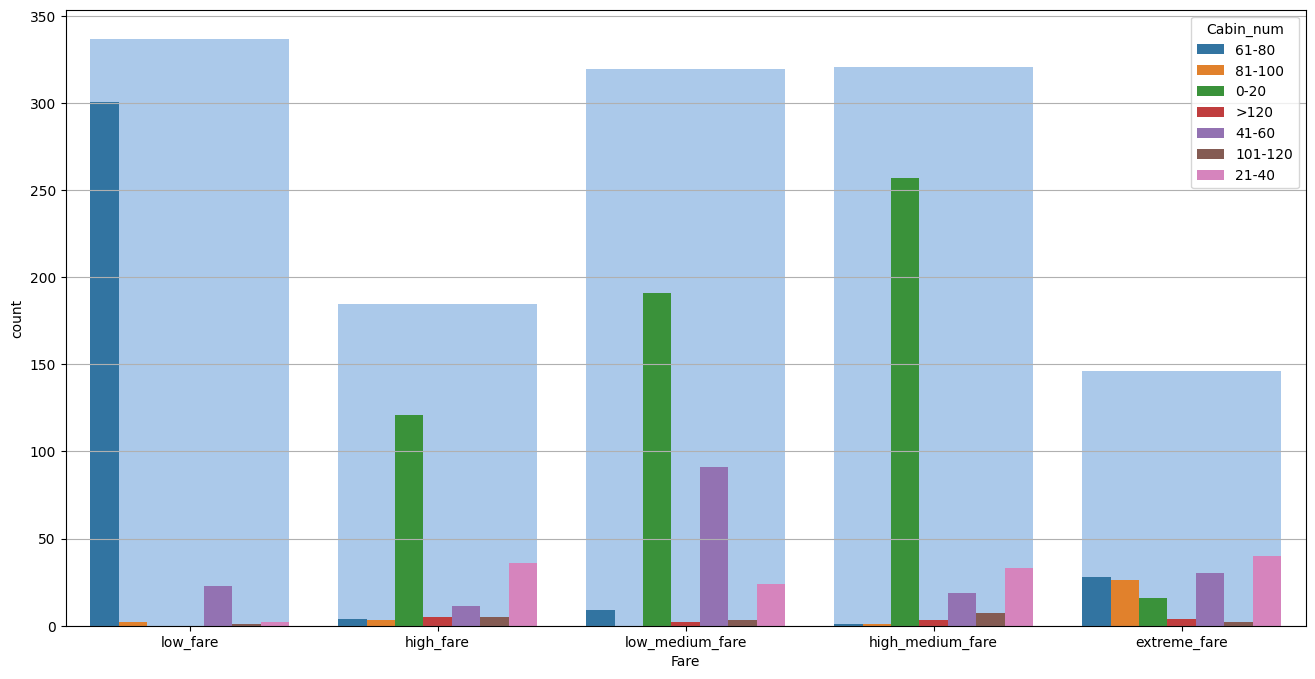

In [124]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Fare', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Fare', hue='Cabin_num')

#### Pclass

<Axes: xlabel='Pclass', ylabel='count'>

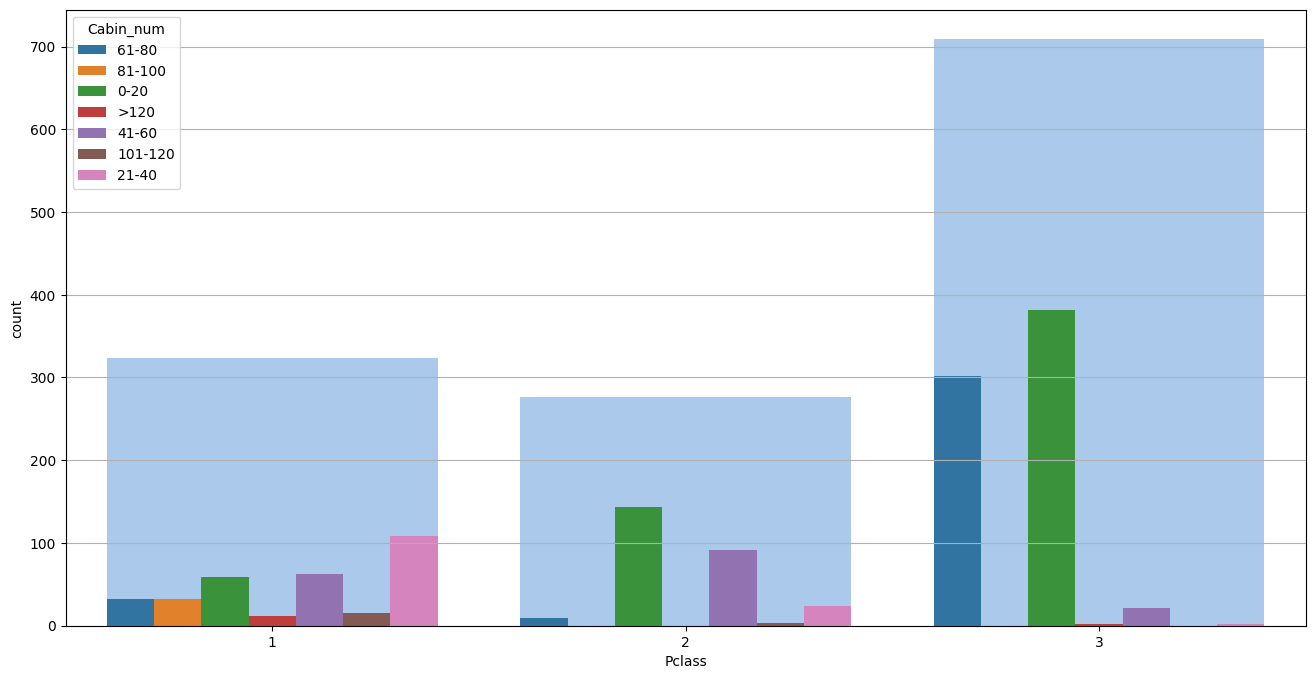

In [125]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Pclass', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Pclass', hue='Cabin_num')

#### Sex

<Axes: xlabel='Sex', ylabel='count'>

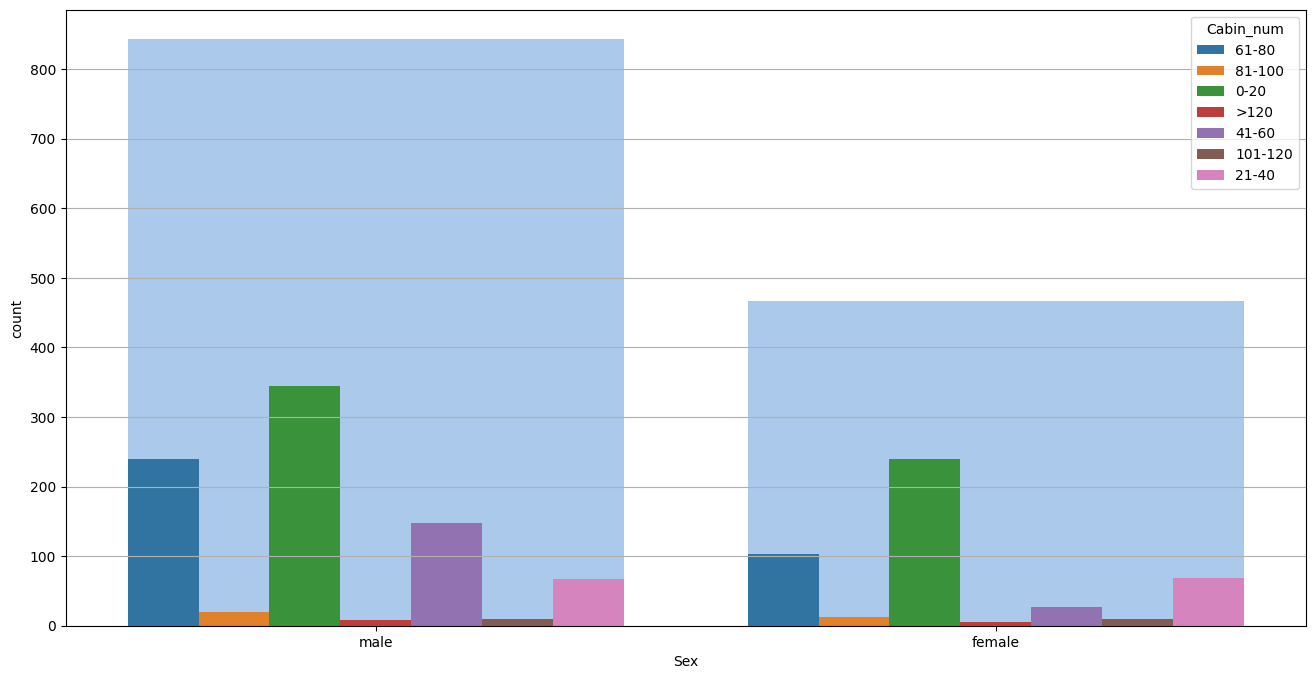

In [126]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Sex', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Sex', hue='Cabin_num')

#### Age

<Axes: xlabel='Age', ylabel='count'>

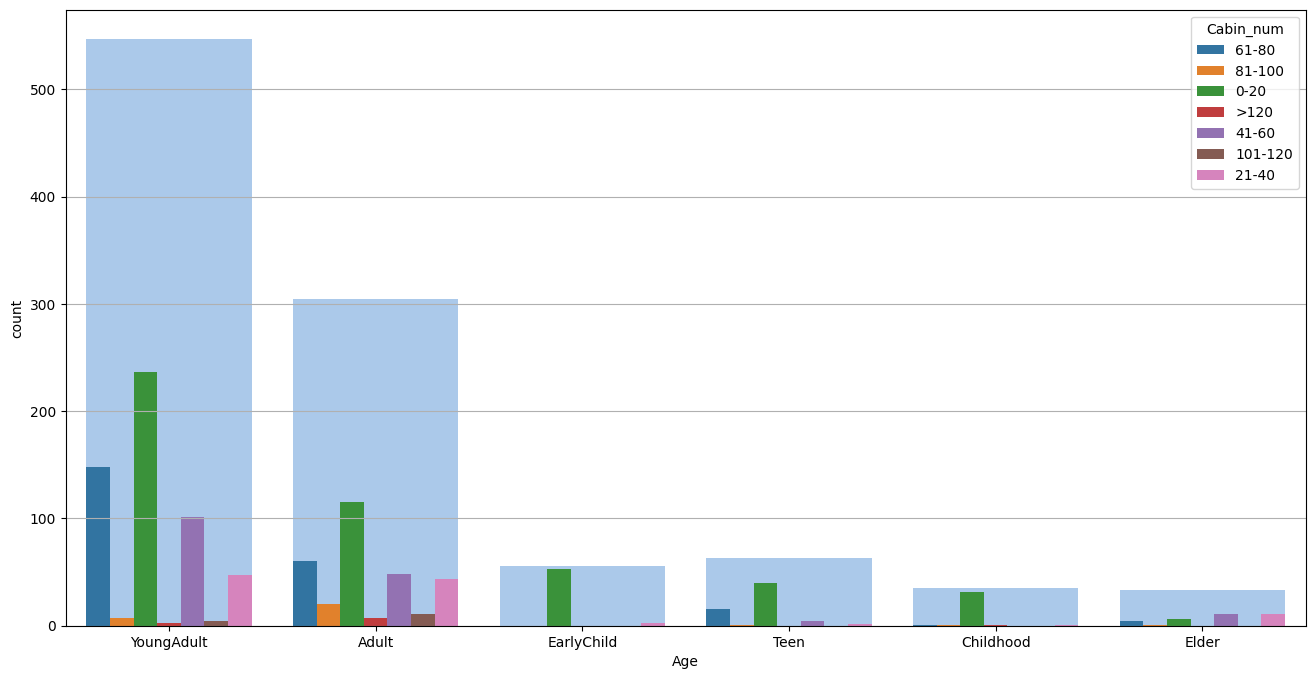

In [127]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Age', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Age', hue='Cabin_num')

#### Embarked

<Axes: xlabel='Embarked', ylabel='count'>

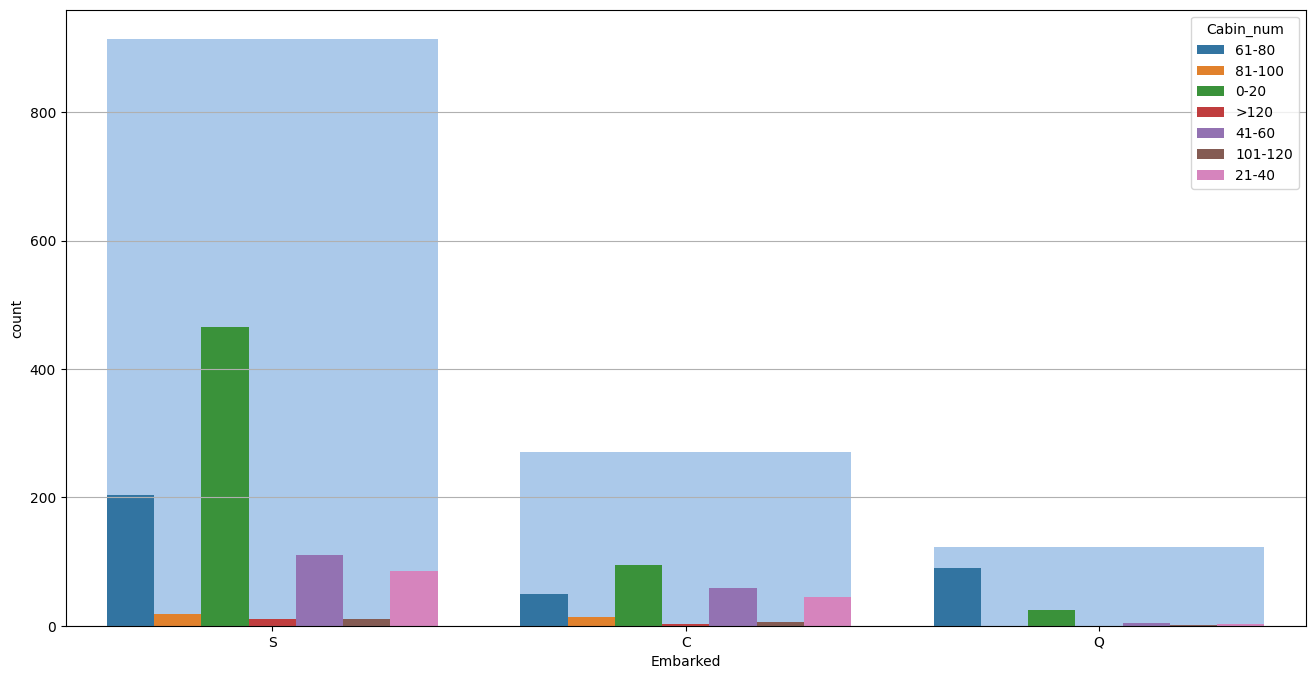

In [128]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Embarked', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Embarked', hue='Cabin_num')

#### Family

<Axes: xlabel='Family', ylabel='count'>

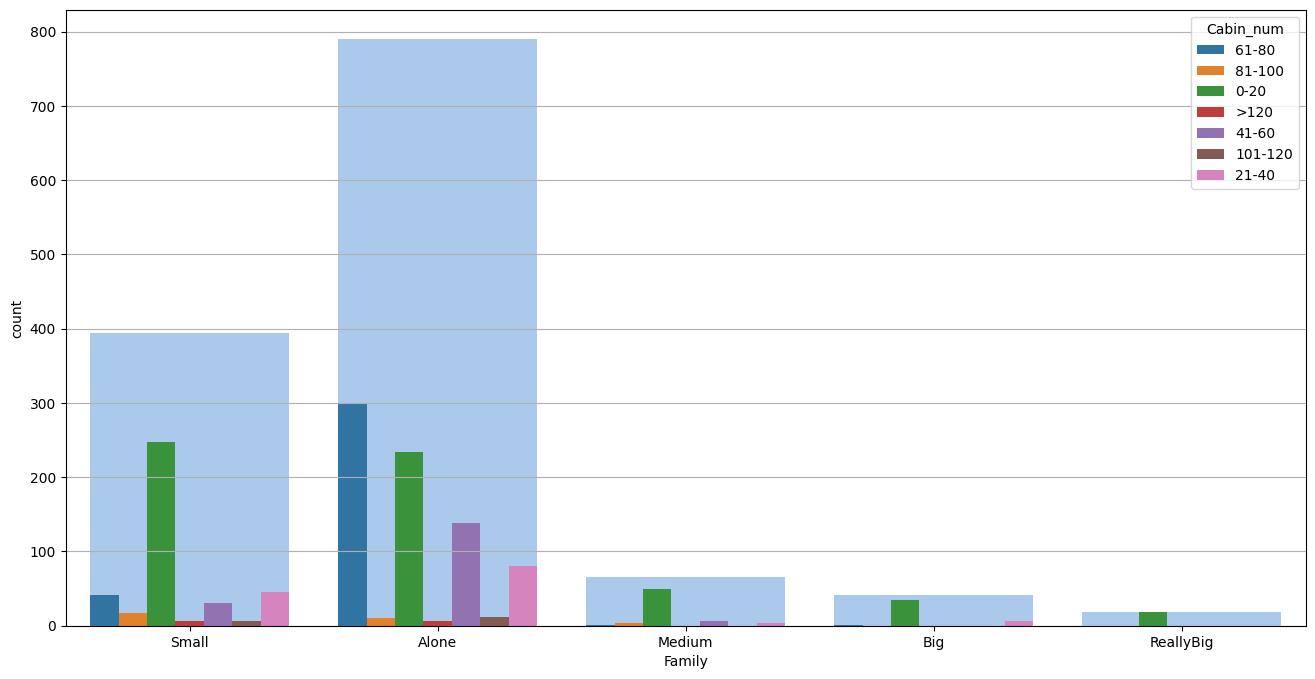

In [129]:
plt.figure(figsize=(16,8))
plt.grid()
sns.set_color_codes('pastel')
sns.countplot(data=X, x='Family', color='b')
sns.set_color_codes('muted')
sns.countplot(data=X, x='Family', hue='Cabin_num')

# Final Cabin column

With both Cabin_letter and Cabin_num completly imputed, it's just a matter of combining them to get the restored Cabin column

In [130]:
X['Restored_Cabin'] = X['Cabin_letter'] + X['Cabin_num']
X

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Cabin_letter,Cabin_num,Family,Restored_Cabin
PassengerId,,,,,,,,,,,,
1,3,mr,male,YoungAdult,A/5 21171,low_fare,NaN,S,G,61-80,Small,G61-80
2,1,mrs,female,Adult,PC 17599,high_fare,C85,C,C,81-100,Small,C81-100
3,3,miss,female,YoungAdult,STON/O2. 3101282,low_medium_fare,NaN,S,G,0-20,Alone,G0-20
4,1,mrs,female,Adult,113803,high_fare,C123,S,C,>120,Small,C>120
5,3,mr,male,Adult,373450,low_medium_fare,NaN,S,E,0-20,Alone,E0-20
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,mr,male,None,A.5. 3236,low_medium_fare,NaN,S,E,0-20,Alone,E0-20
1306,1,dona,female,Adult,PC 17758,extreme_fare,C105,C,C,101-120,Alone,C101-120
1307,3,mr,male,Adult,SOTON/O.Q. 3101262,low_fare,NaN,S,G,61-80,Alone,G61-80


# Model

In order to check the importance of the Cabin in the prediction of the passenger survival, let's train a simple SVM (Support Vector Machine) and make predictions using only the info from that column.

In [131]:
#Select columns from dataset and apply dummy encoding
X_ = X[['Cabin_letter', 'Cabin_num']].copy()
X_ = pd.get_dummies(X_, dtype=int)
X_test = X_.iloc[891:].copy()
X_.drop(X_test.index, inplace=True)
Y = df_train['Survived'].copy()

In [132]:
X_

,Cabin_letter_A,Cabin_letter_B,Cabin_letter_C,Cabin_letter_D,Cabin_letter_E,Cabin_letter_F,Cabin_letter_G,Cabin_num_0-20,Cabin_num_101-120,Cabin_num_21-40,Cabin_num_41-60,Cabin_num_61-80,Cabin_num_81-100,Cabin_num_>120
PassengerId,,,,,,,,,,,,,,
1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,0,0,1,0,0,0,0,0,0,1,0,0,0
888,0,1,0,0,0,0,0,0,0,0,1,0,0,0
889,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [133]:
#Split in training and validation data
X_train, X_val, Y_train, Y_val = train_test_split(X_, Y)

In [134]:
model = SVC()
model.fit(X_train, Y_train)
pred = model.predict(X_val)

In [135]:
print('Accuracy: {:.4f}'.format(accuracy_score(Y_val, pred)))
print('R2 Score: {:.4f}'.format(precision_score(Y_val, pred)))

Accuracy: 0.7085
R2 Score: 0.7045


As we can see, almost a 0.7 score is obtained just with the Cabin column, a simple model and very little processsing after the column was restored

In [136]:
prediction = model.predict(X_test)
pd.DataFrame(prediction, columns = ['Survived'], index=df_test['PassengerId']).to_csv('/kaggle/working/submission5.csv')

It's important to mention that this is just an aproximation of what the Cabin column would look like if it was complete, since most of the values in the original column are null and very little data is proportioned to do the analysis. 

The result is also highly dependent in the applied feature engineering and the selected columns to make the similarity analysis, so just take this as a reference. 

If you found this notebook helpful or interesing, leave an upvote and let me know your thoughts in the comments, any feedback is valuable!

Thanks for watching!
